In [1]:
#makes sure to reload our modules on each execution

%load_ext autoreload 
%autoreload 1
%aimport gans, preprocessing, sourceSeparation, thresholding, testingPipeline

import concurrent.futures
import matplotlib.pyplot as plt
import torch
import pickle
import numpy as np
import math

In [2]:
# data init

# dataset
baseDatasetPath = "../data/datasets"
inclusionThreshold = 0.5
includedSims = 24

# iters to run
iters = [1,2,3,4,5,6,7,8,9,10]

snrs=range(1,7)

#SDs to test
sdMuls = list(range(1, 6))

# gans
batchSize = 64
baseModelPath = "../data/models"
epochs = 5
noiseDim = 200

#results
resultsPath = "../data/results"

<AxesSubplot:>

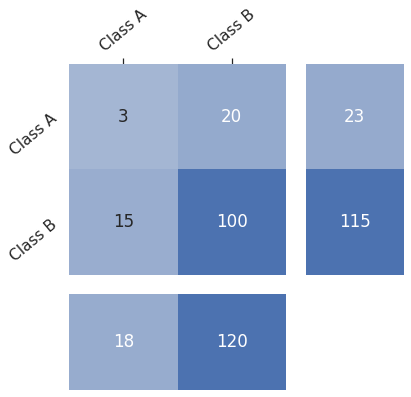

In [68]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

array = np.array([[3,  20],
                      [ 15, 100]])

classes = ["Class A", "Class B"]

#df_cm = pd.DataFrame(array, index=classes, columns=classes)
# plt.figure(figsize=(10,7))
#sn.set(font_scale=1.4) # for label size
#sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

#plt.show()
from matplotlib.pyplot import figure

fig = plt.figure(figsize=(6,6))
ax1 = plt.subplot2grid((3,3), (0,0), colspan=2, rowspan=2)
ax2 = plt.subplot2grid((3,3), (2,0), colspan=2, rowspan=1)
ax3 = plt.subplot2grid((3,3), (0,2), colspan=1, rowspan=2)
sn.color_palette("Paired")
pv = pd.DataFrame(array, index=classes, columns=classes)

c = sn.color_palette("light:b", as_cmap=True)

sn.heatmap(pv, ax=ax1,cmap=c, annot=True, linecolor='b', cbar = False,fmt='d',center=np.mean(pv)[0])
ax1.xaxis.tick_top()
ax1.set_xticklabels(classes,rotation=40)
ax1.set_yticklabels(classes,rotation=40)

sn.heatmap((pd.DataFrame(np.sum(pv,axis=0))).transpose(), ax=ax2,cmap=c,  annot=True, cbar=False, xticklabels=False, yticklabels=False,fmt='d',center=np.mean(pv,axis=0)[0])
sn.heatmap(pd.DataFrame(np.sum(pv,axis=1)), ax=ax3,  annot=True,cmap=c, cbar=False, xticklabels=False, yticklabels=False,fmt='d',center=np.mean(pv,axis=1)[0])


In [4]:
i = 1
snr = 6

genSpike = gans.GeneratorWgan(inputSize=noiseDim, hiddenSize=80, outputSize=80)
criticSpike = gans.CriticWgan(inputSize=80, hiddenSize=40)
genSpike.load_state_dict(torch.load(f"{baseModelPath}/it-{i}-gen-spike.pth"))
genSpike.to(gans.device)
criticSpike.load_state_dict(torch.load(f"{baseModelPath}/it-{i}-critic-spike.pth"))
criticSpike.to(gans.device)

genNoise = gans.GeneratorWgan(inputSize=noiseDim, hiddenSize=80, outputSize=80)
criticNoise = gans.CriticWgan(inputSize=80, hiddenSize=40)
genNoise.load_state_dict(torch.load(f"{baseModelPath}/it-{i}-gen-noise.pth"))
genNoise.to(gans.device)
criticNoise.load_state_dict(torch.load(f"{baseModelPath}/it-{i}-critic-noise.pth"))
criticNoise.to(gans.device)

# separating noise as it is the same for all snrs
print(f"\nSeparating dataset with snr {snr}\n")


print("Separating validation spikes")

errs = np.zeros((9,5))
eps = [1, 100, 300, 600, 1000, 2000, 3000, 4000, 5000]
for it in range(5):
    print(f"{it} iterations")
    valBgLoader = pickle.load(open(f"{baseDatasetPath}/it-{it}-non-drowned-valBgLoader.pickle", "rb"))
    testBgLoader = pickle.load(open(f"{baseDatasetPath}/it-{it}-non-drowned-testBgLoader.pickle", "rb"))
    valSpikesLoader = pickle.load(open(f"{baseDatasetPath}/it-{it}-snr-{snr}-valSpikesLoader.pickle", "rb"))

    for ep in eps:
        print(f"{ep} epochs")
        (cleanextractedSpikesValidationSpikes,cleanextractedNoisesValidationSpikes, err) = sourceSeparation.maxlikelihood_separatesources(
            generators=[genSpike, genNoise],
            discriminators=[criticSpike, criticNoise],
            loader_mix=valSpikesLoader,
            epochs=ep,
            doPrint=True
        )

        errs[eps.index(ep)][it] = (err)
        print(err)


Separating dataset with snr 6

Separating validation spikes
0 iterations


FileNotFoundError: [Errno 2] No such file or directory: '../data/datasets/it-0-non-drowned-valBgLoader.pickle'

In [3]:
# constants

batchSize = 64
noiseDim = 200
includedSimulations=24



In [76]:
# generates preprocessed datasets for our models and saves them to disk
snr = 1
toSave = "1.0"

trainSpikesLoader, valSpikesLoader, testSpikesLoader, trainBgLoader, valBgLoader, testBgLoader = preprocessing.gen_loaders( 
    batchSize,
    1,
    doDrown=False,
    snr=snr,
    inclusionThreshold=0.5
)

pickle.dump(trainSpikesLoader, open(f"../data/datasets/trainSpikesLoader{toSave}.pickle", "wb"))
pickle.dump(valSpikesLoader, open(f"../data/datasets/valSpikesLoader{toSave}.pickle", "wb"))
pickle.dump(testSpikesLoader, open(f"../data/datasets/testSpikesLoader{toSave}.pickle", "wb"))
pickle.dump(trainBgLoader, open(f"../data/datasets/trainBgLoader{toSave}.pickle", "wb"))
pickle.dump(valBgLoader, open(f"../data/datasets/valBgLoader{toSave}.pickle", "wb"))
pickle.dump(testBgLoader, open(f"../data/datasets/testBgLoader{toSave}.pickle", "wb"))

Simularea 1


In [78]:
print(trainSpikesLoader.dataset[:][0].shape)

torch.Size([8521, 80])


In [59]:
#loads preprocessed datasets from disk
toLoad1 = "orig"
toLoad2 = ".snr.1.0"

trainSpikesLoader = pickle.load(open(f"../data/datasets/trainSpikesLoader{toLoad1}.pickle", "rb"))
valSpikesLoader = pickle.load(open(f"../data/datasets/valSpikesLoader{toLoad2}.pickle", "rb"))
testSpikesLoader = pickle.load(open(f"../data/datasets/testSpikesLoader{toLoad2}.pickle", "rb"))
trainBgLoader = pickle.load(open(f"../data/datasets/trainBgLoader{toLoad1}.pickle", "rb"))
valBgLoader = pickle.load(open(f"../data/datasets/valBgLoader{toLoad2}.pickle", "rb"))
testBgLoader = pickle.load(open(f"../data/datasets/testBgLoader{toLoad2}.pickle", "rb"))

In [74]:
res = testingPipeline.testThresholding(1, 5, trainSpikesLoader, valSpikesLoader, testSpikesLoader, trainBgLoader, valBgLoader, testBgLoader)

for x in res:
    print(f"{x} * sd")
    
    [labels, pred] = res[x]
    
    confusionMatrix = testingPipeline.confusionMatrix(labels,pred)
    print(confusionMatrix)

    accuracy, sensitivity, specificity = testingPipeline.metrics(confusionMatrix)

    print(f"Accuracy: {accuracy}")
    print(f"Sensitivity: {sensitivity}")
    print(f"Specificity: {specificity}")
    print()

1 * sd
[[ 4376 16254]
 [ 1064 19565]]
Accuracy: 0.5802612763275892
Sensitivity: 0.9484221241940957
Specificity: 0.21211827435773145

2 * sd
[[16905  3725]
 [10231 10398]]
Accuracy: 0.6617465280302479
Sensitivity: 0.5040476998400311
Specificity: 0.8194377120698012

3 * sd
[[20144   486]
 [16930  3699]]
Accuracy: 0.5778860369858697
Sensitivity: 0.1793106791410151
Specificity: 0.97644207464857

4 * sd
[[20563    67]
 [19398  1231]]
Accuracy: 0.5282241450350227
Sensitivity: 0.059673275485966355
Specificity: 0.996752302472128

5 * sd
[[20625     5]
 [20204   425]]
Accuracy: 0.5101917157468674
Sensitivity: 0.020602065054050125
Specificity: 0.9997576345128454



In [62]:
mean, sd = thresholding.computeThreshold(trainSpikesLoader, valSpikesLoader, testSpikesLoader, trainBgLoader, valBgLoader, testBgLoader)

pred = thresholding.thresholdDatasets(mean, 3 * sd, testSpikesLoader, testBgLoader)

labels = np.concatenate(([1 for _ in range(0,len(testSpikesLoader.dataset))],[0 for _ in range(0,len(testBgLoader.dataset))]),axis=0)

confusionMatrix = testingPipeline.confusionMatrix(labels,pred)
print(confusionMatrix)

accuracy, sensitivity, specificity = testingPipeline.metrics(confusionMatrix)

print(f"Accuracy: {accuracy}")
print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")

[[20144.   486.]
 [16930.  3699.]]
Accuracy: 0.5778860369858697
Sensitivity: 0.1793106791410151
Specificity: 0.97644207464857


Spike generator training


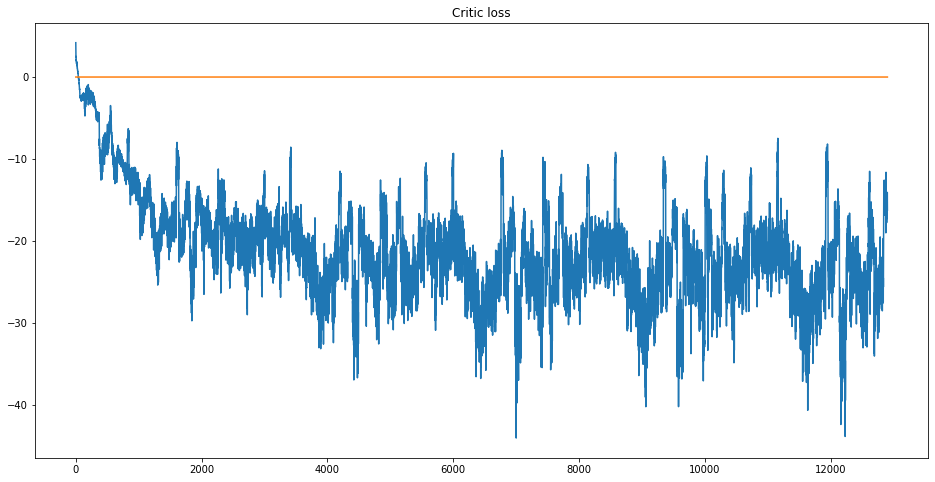

Critic loss -16.234445571899414

Epoch 4

Generated example:


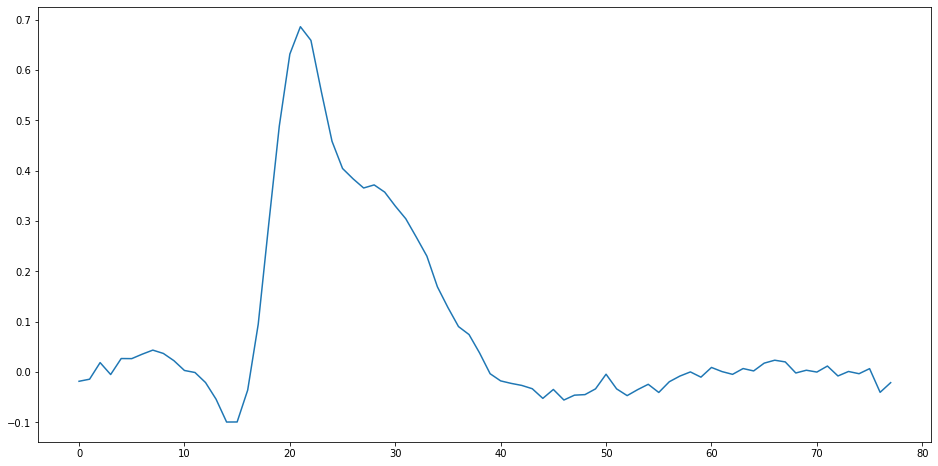

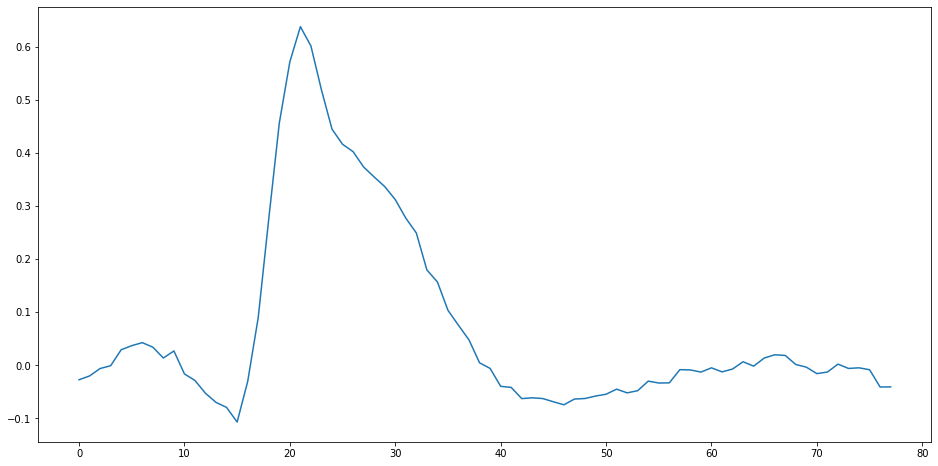

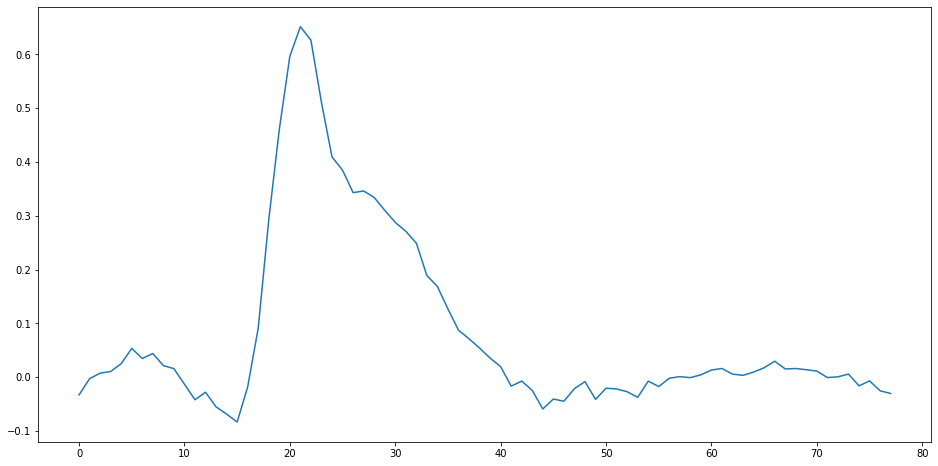

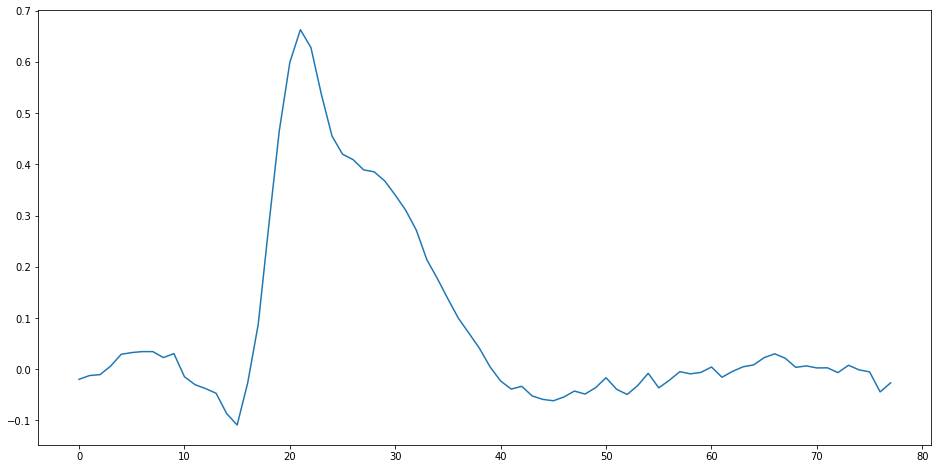

In [4]:
# declares and trains the gan for spikes 

gen1 = gans.GeneratorWgan(inputSize=noiseDim, hiddenSize=80, outputSize=80)
critic1 = gans.CriticWgan(inputSize=80, hiddenSize=40)

print("Spike generator training")

gans.wgan_adversarial_trainer( 
    train_loader = trainSpikesLoader,
    generator = gen1, 
    critic = critic1, 
    batchSize = batchSize,
    noiseDim = noiseDim,
    epochs = 5,
)

Background generator training


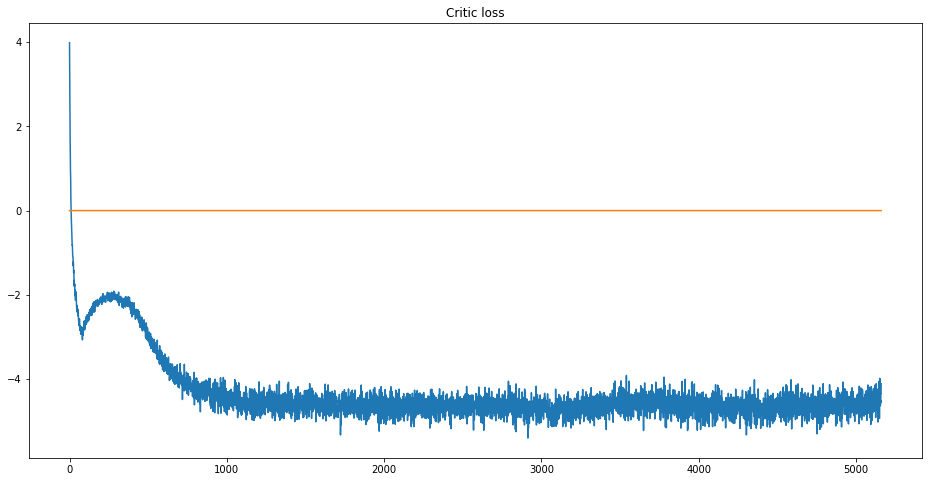

Critic loss -4.1110944747924805

Epoch 1

Generated example:


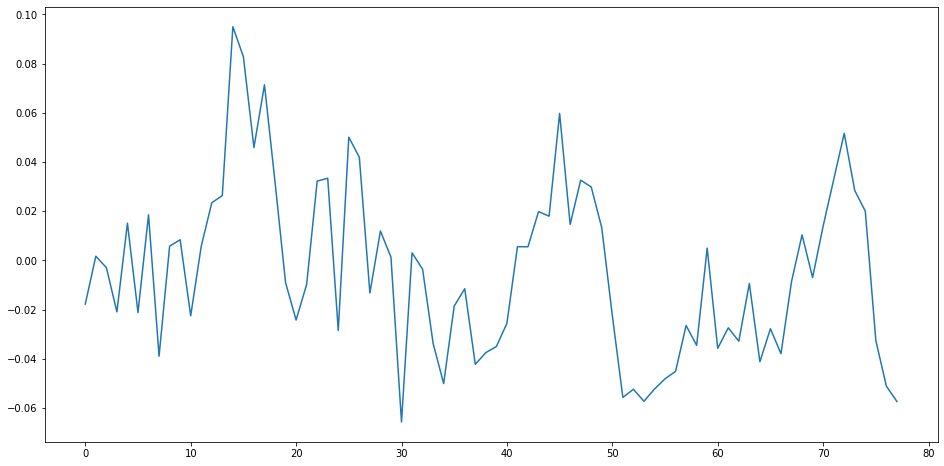

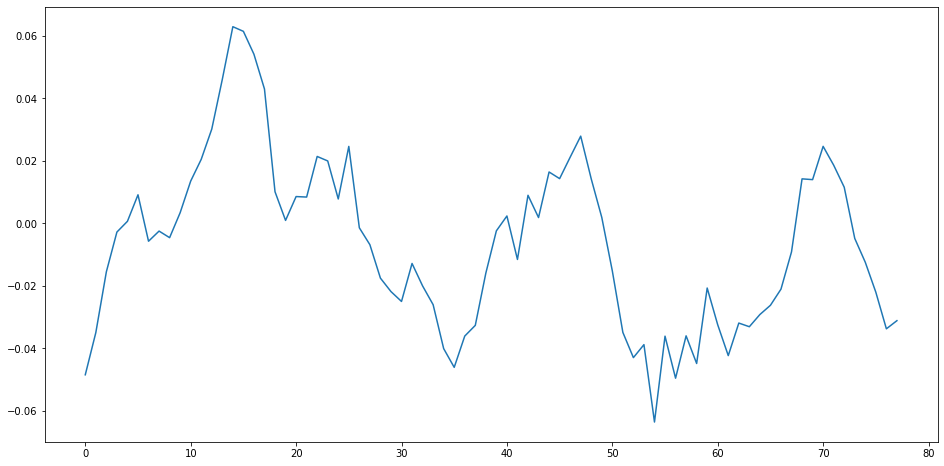

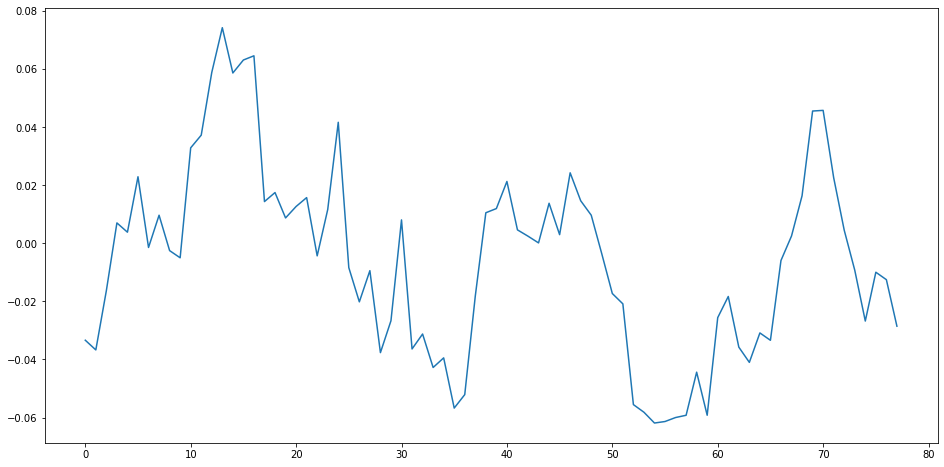

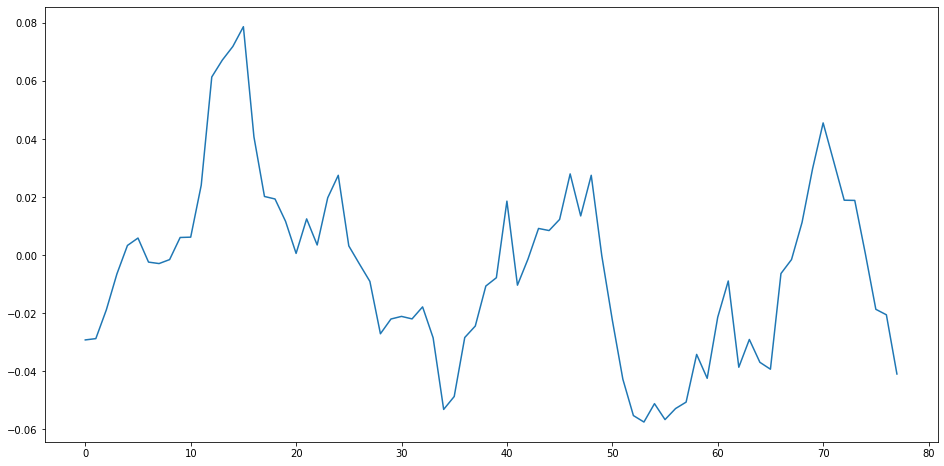

In [5]:
# declares and trains the gan for hash

gen2 = gans.GeneratorWgan(inputSize=noiseDim, hiddenSize=10, outputSize=80)
critic2 = gans.CriticWgan(inputSize=80, hiddenSize=40)
print("Background generator training")

gans.wgan_adversarial_trainer( 
    train_loader = trainBgLoader,
    generator = gen2, 
    critic = critic2, 
    batchSize = batchSize,
    noiseDim = noiseDim,
    epochs = 2,
)

In [9]:
torch.save(gen1.state_dict(),"../data/models/gen1.orig.pth")
torch.save(critic1.state_dict(),"../data/models/critic1.orig.pth")
torch.save(gen2.state_dict(),"../data/models/gen2.orig.pth")
torch.save(critic2.state_dict(),"../data/models/critic2.orig.pth")

In [5]:
toLoad1 = "orig"
gen1 = gans.GeneratorWgan(inputSize=noiseDim, hiddenSize=80, outputSize=80)
critic1 = gans.CriticWgan(inputSize=80, hiddenSize=40)
gen1.load_state_dict(torch.load(f"../data/models/gen1.{toLoad1}.pth"))
gen1.to(gans.device)
critic1.load_state_dict(torch.load(f"../data/models/critic1.{toLoad1}.pth"))
critic1.to(gans.device)

gen2 = gans.GeneratorWgan(inputSize=noiseDim, hiddenSize=10, outputSize=80)
critic2 = gans.CriticWgan(inputSize=80, hiddenSize=40)
gen2.load_state_dict(torch.load(f"../data/models/gen2.{toLoad1}.pth"))
gen2.to(gans.device)
critic2.load_state_dict(torch.load(f"../data/models/critic2.{toLoad1}.pth"))
critic2.to(gans.device)

_netC_wgan(
  (mainModule): Sequential(
    (0): Linear(in_features=80, out_features=40, bias=True)
    (1): Tanh()
    (2): Linear(in_features=40, out_features=1, bias=True)
  )
)

In [35]:
allPrecision = []
allRecall = []
allF1 = []
allAccuracy = []
allSpecificity = []

for snr in [x/2 for x in range(12,0,-1)]:
    toLoad2 = f".snr.{snr}"
    
    print(toLoad2)

    valSpikesLoader = pickle.load(open(f"../data/datasets/valSpikesLoader{toLoad2}.pickle", "rb"))
    testSpikesLoader = pickle.load(open(f"../data/datasets/testSpikesLoader{toLoad2}.pickle", "rb"))
    valBgLoader = pickle.load(open(f"../data/datasets/valBgLoader{toLoad2}.pickle", "rb"))
    testBgLoader = pickle.load(open(f"../data/datasets/testBgLoader{toLoad2}.pickle", "rb"))
    
    (cleanextractedSpikesValidationSpikes,cleanextractedNoisesValidationSpikes) = sourceSeparation.maxlikelihood_separatesources(
        generators=[gen1, gen2],
        loader_mix=valSpikesLoader,
        epochs=3000
    )
    
    (cleanextractedSpikesValidationBg,cleanextractedNoisesValidationBg) = sourceSeparation.maxlikelihood_separatesources(
        generators=[gen1, gen2],
        loader_mix=valBgLoader,
        epochs=3000
    )
    
    valExtractedSpikes = np.concatenate((cleanextractedSpikesValidationSpikes,cleanextractedSpikesValidationBg),axis=0)
    vallabel = np.concatenate(([1 for _ in cleanextractedSpikesValidationSpikes],[0 for _ in cleanextractedSpikesValidationBg]),axis=0)
    
    valThreshold, _, _, _, _, _ = sourceSeparation.interpretSeparation(valExtractedSpikes, critic1, vallabel,method="energy")
    
    (cleanextractedSpikesTestSpikes,cleanextractedNoisesTestSpikes) = sourceSeparation.maxlikelihood_separatesources(
        generators=[gen1, gen2],
        loader_mix=testSpikesLoader,
        epochs=3000
    )
    
    (cleanextractedSpikesTestBg,cleanextractedNoisesTestBg) = sourceSeparation.maxlikelihood_separatesources(
        generators=[gen1, gen2],
        loader_mix=testBgLoader,
        epochs=3000
    )
    
    testExtractedSpikes = np.concatenate((cleanextractedSpikesTestSpikes,cleanextractedSpikesTestBg),axis=0)
    testlabel = np.concatenate(([1 for _ in cleanextractedSpikesTestSpikes],[0 for _ in cleanextractedSpikesTestBg]),axis=0)
    
    (_, precision, recall, spec, f1, acc) = sourceSeparation.interpretSeparation(testExtractedSpikes, critic1, testlabel,test=True, testThreshold=valThreshold,method="energy")
    
    allPrecision.append(precision)
    allRecall.append(recall)
    allF1.append(f1)
    allAccuracy.append(acc)
    allSpecificity.append(spec)
    
    

.snr.6.0


NameError: name 'gen1' is not defined

Accuracy
[0.988341937516663, 0.9854819554521438, 0.9824765505707845, 0.9781623403378656, 0.9737511815603869, 0.965486318136649, 0.9526891102547324, 0.9335417727041373, 0.9073656656729441, 0.8720279211808333, 0.8013039579243316, 0.6681451319712063]
Precision
[0.9910313901345291, 0.9878702260327358, 0.9833430458430459, 0.9810299424558666, 0.9749708398133748, 0.967479674796748, 0.9536555744474131, 0.9415452974574179, 0.8990834401861614, 0.8692326196776522, 0.7802931228861331, 0.6199052788052685]
Recall
[0.9856027921857579, 0.9830335934848999, 0.9815793300693199, 0.9751805710407678, 0.9724659459983518, 0.9633525619273838, 0.9516215037083717, 0.9244752532842115, 0.9177371661253575, 0.8758059043094673, 0.8387706626593631, 0.8692617189393572]
Specificity
[0.9910809500727097, 0.9879301987396994, 0.9833737275811925, 0.9811439650993699, 0.9750363548230732, 0.9676199709161415, 0.9537566650508967, 0.9426078526417838, 0.8969946679592826, 0.8682501211827436, 0.7638390693165293, 0.4670382937469704]
F

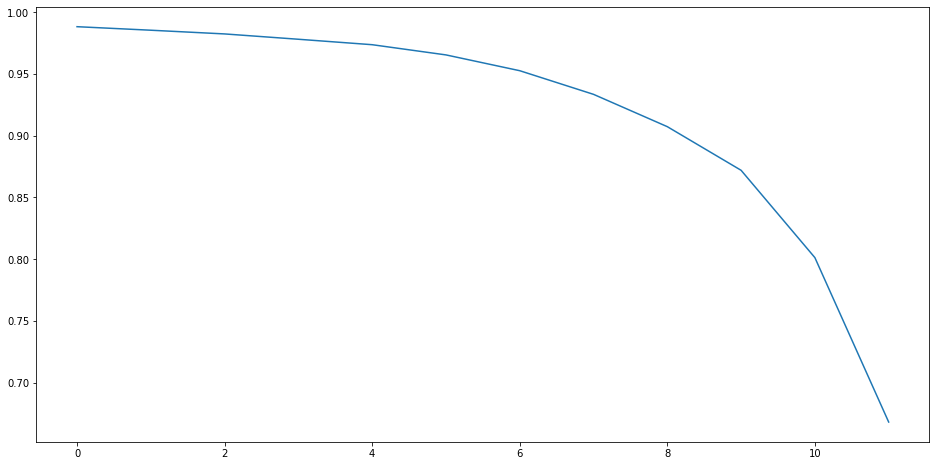

In [16]:
print("Accuracy")
print(allAccuracy)
print("Precision")
print(allPrecision)
print("Recall")
print(allRecall)
print("Specificity")
print(allSpecificity) 
print("F1")
print(allF1)
print("snrs")
print([x/2 for x in range(12,0,-1)])
plt.plot(allAccuracy)
plt.show()


In [1]:
allAccuracy = [0.988293463244383, 0.9855789039967038, 0.9827431590683244, 0.9781623403378656, 0.9737027072881068, 0.965437843864369, 0.9527375845270123, 0.9335902469764172, 0.907680748442764, 0.8720036840446933, 0.8016190406941516, 0.6679754720182264]
allPrecision = [0.9909826476896081, 0.9877300613496932, 0.983492741661407, 0.980842351564785, 0.9748299319727891, 0.9676586625103502, 0.953836435200933, 0.9416382758109909, 0.8994869846095382, 0.8688713708902134, 0.7805229936880073, 0.6198713069950875]
allRecall = [0.985554316738572, 0.9833729216152018, 0.9819671336468079, 0.9753744728295118, 0.9725144214455378, 0.9630617092442678, 0.9515245528139997, 0.9244752532842115, 0.9179310679141015, 0.8762421833341413, 0.8392069416840371, 0.8685830626787532]
allF1 = [0.9882610280714546, 0.9855466757354191, 0.9827293455586281, 0.9781007704834359, 0.9736708000679463, 0.965354713313897, 0.9526790914385557, 0.9329778386575999, 0.9086154362899163, 0.8725412111119156, 0.8088018874535731, 0.7234480670233168]
accDict = {1: [0.6157444436365399, 0.61530817518602, 0.61509004096076, 0.6173198574856394, 0.6122542960323808, 0.6104365108218813, 0.6083763542499818, 0.603722824111103, 0.603795535519523, 0.5976393029399646, 0.5802612763275892, 0.5535761894374561], 2: [0.8998521534695461, 0.8953925204197872, 0.8865944400009694, 0.8777963595821517, 0.865411183014615, 0.8485906105334594, 0.8263651566930852, 0.7979592331370126, 0.7600281150779223, 0.7182675295087132, 0.6617465280302479, 0.592137473036186], 3: [0.8571947938631571, 0.8397440558423617, 0.8216631522819263, 0.7954870452507332, 0.773164642865799, 0.7449283792627063, 0.7130323081024746, 0.6810392883976829, 0.6453622239996122, 0.6141690297874404, 0.5778860369858697, 0.5414091470951793], 4: [0.7152378874912141, 0.695920889987639, 0.6801425143605032, 0.6586199374681888, 0.642259870573693, 0.6183620543396592, 0.5987784483385443, 0.5813277103177489, 0.5609200416878741, 0.5454325116944182, 0.5282241450350227, 0.5138515233040064], 5: [0.6145083496934002, 0.6010082648634237, 0.5890351196102669, 0.5742747037010106, 0.5682881310744322, 0.5524855183111563, 0.5422332097239391, 0.5344288518868611, 0.5251460287452434, 0.5163721854625657, 0.5101917157468674, 0.503938534622749]}
precisionDict = {1: [0.5654593809119074, 0.5651768832378813, 0.5650517893352331, 0.5664725594682195, 0.5632805881227624, 0.5621453513749455, 0.5609643022716736, 0.5582700111664897, 0.5587186660084471, 0.5555249228054698, 0.5462184873949579, 0.5318058833688332], 2: [0.8563836681788723, 0.8554804968402702, 0.8498420775574662, 0.8470410117112704, 0.8432604735883424, 0.8360280373831775, 0.8269314815714077, 0.8160316725795671, 0.7963863410321582, 0.7730277120853799, 0.7362458401189549, 0.6662002623524268], 3: [0.9754791249919339, 0.9742201772785709, 0.972176759410802, 0.9688485501115299, 0.9647806004618937, 0.9597779597779598, 0.9510417735810326, 0.9422143280047365, 0.9290313349549292, 0.9175531914893617, 0.8838709677419355, 0.8234848484848485], 4: [0.9957570343903528, 0.9949785670545009, 0.9948069241011984, 0.991882140709561, 0.9926137317441666, 0.9887887887887888, 0.9894306990151334, 0.9838477069512547, 0.9783022459078797, 0.9756345177664975, 0.948382126348228, 0.9192364170337739], 5: [0.9993657505285413, 0.9995204986813714, 0.9991845610220168, 0.9990228013029316, 0.9989373007438895, 0.9990779160903642, 0.9971461187214612, 0.9978962131837307, 0.9933396764985728, 0.9927007299270073, 0.9883720930232558, 0.9821428571428571]}
recallDict = {1: [0.99975762276407, 0.999806098211256, 0.999612196422512, 0.999709147316884, 0.999127441950652, 0.998885064714722, 0.997139948616026, 0.993649716418634, 0.987541810073198, 0.9767802607979058, 0.9484221241940957, 0.8956323622085414], 2: [0.9608318386737118, 0.9515245528139997, 0.9391148383343836, 0.9220999563720975, 0.8976683309903534, 0.8672742256047312, 0.825488390130399, 0.7693538222890106, 0.6986766202918222, 0.6179650007271317, 0.5040476998400311, 0.3692859566629502], 3: [0.7328033351107665, 0.6979494885840322, 0.6622715594551359, 0.6105967327548597, 0.5670173057346454, 0.511270541470745, 0.4491734936254787, 0.3857191332590043, 0.3147510785786999, 0.2508604391875515, 0.1793106791410151, 0.10538562218236464], 4: [0.4323040380047506, 0.3938145329390664, 0.36216006592660815, 0.31984100053322995, 0.2866353192108197, 0.23942023365165543, 0.1996703669591352, 0.165349750351447, 0.12458189926802075, 0.09316980949149256, 0.059673275485966355, 0.030345629938436182], 5: [0.22914343884822339, 0.2020941393184352, 0.17819574385573708, 0.1486741965194629, 0.1367007610645208, 0.10504629405206263, 0.0846866062339425, 0.06898056134567841, 0.050608366862184305, 0.0329633040864802, 0.020602065054050125, 0.007998448785690048]}
f1Dict = {1: [0.7223564848866939, 0.7221385805819125, 0.7219858900968086, 0.7231699833435609, 0.7204124432016776, 0.7194204416513923, 0.7180006282941812, 0.7148885711296342, 0.7136676533954563, 0.7082476582133882, 0.693204365079365, 0.667352946488234], 2: [0.90560606752867, 0.9009501078624867, 0.8922510074841681, 0.882978229587337, 0.8696142196341777, 0.8513645340122297, 0.8262093057105429, 0.7920055891012526, 0.7443385751542851, 0.6868534482758621, 0.5984116022099448, 0.47517465069860276], 3: [0.8369041687427337, 0.8132625395390872, 0.7878438383022892, 0.7490930716622064, 0.7142551827313528, 0.6671516224935162, 0.6101672593177927, 0.5473619041067621, 0.4702005938156275, 0.39400053294758086, 0.29813814781977915, 0.18685805148480814], 4: [0.6028730775730945, 0.5642842258803917, 0.5310067877323288, 0.4837066089952715, 0.44482058226134047, 0.3854979706525133, 0.3322846079380445, 0.28311752988047806, 0.2210182318541452, 0.1700960219478738, 0.11228166187804987, 0.058751759737212576], 5: [0.37280649867897003, 0.3362096774193548, 0.3024518676978773, 0.2588294864762226, 0.24049121610097218, 0.19010439512237914, 0.15611456145837987, 0.1290410337791884, 0.09630996309963101, 0.06380782584216946, 0.04036279025594758, 0.01586767322209934]}
multiplesOfSd = list(range(1,6))

In [13]:
multiplesOfSd = list(range(1,6))

accDict = {}
precisionDict = {}
recallDict = {}
specDict = {}
f1Dict = {}

for x in multiplesOfSd:
    accDict[x] = []
    precisionDict[x] = []
    recallDict[x] = []
    f1Dict[x] = []
    specDict[x] = []
    

for snr in [x/2 for x in range(12,0,-1)]:
    toLoad2 = f".snr.{snr}"
    
    print(toLoad2)
    
    valSpikesLoader = pickle.load(open(f"../data/datasets/valSpikesLoader{toLoad2}.pickle", "rb"))
    testSpikesLoader = pickle.load(open(f"../data/datasets/testSpikesLoader{toLoad2}.pickle", "rb"))
    valBgLoader = pickle.load(open(f"../data/datasets/valBgLoader{toLoad2}.pickle", "rb"))
    testBgLoader = pickle.load(open(f"../data/datasets/testBgLoader{toLoad2}.pickle", "rb"))
    
    mean, sd = thresholding.computeThreshold(trainSpikesLoader, valSpikesLoader, testSpikesLoader, trainBgLoader, valBgLoader, testBgLoader)    

    for sdMultiple in multiplesOfSd:

        print(f"{sdMultiple} * sd")

        testPredictions = thresholding.thresholdDatasets(mean, sd * sdMultiple, testSpikesLoader, testBgLoader)

        testlabel = np.concatenate(([1 for _ in range(0,len(testSpikesLoader.dataset))],[0 for _ in range(0,len(testBgLoader.dataset))]),axis=0)

        truepos = 0
        falsepos = 0
        trueneg = 0
        falseneg = 0

        for i in range(0, len(testlabel)):
            if testlabel[i] == 1:
                if testPredictions[i] == 1:
                    truepos += 1
                else:
                    falseneg += 1
            else:
                if testPredictions[i] == 1:
                    falsepos += 1
                else:
                    trueneg += 1

        precision = truepos / (truepos + falsepos)
        recall = truepos / (truepos + falseneg)  
        f1 = 2 * ((precision * recall)/(precision+recall))
        acc = (truepos + trueneg) / len(testlabel)
        spec = trueneg / (falsepos + trueneg)

        print("Precision: {}".format(precision))
        print("Recall: {}".format(recall))
        print("Specificity: {}".format(spec))
        print("F1: {}".format(f1))
        print("Accuracy: {}".format(acc))

        accDict[sdMultiple].append(acc)
        precisionDict[sdMultiple].append(precision)
        recallDict[sdMultiple].append(recall)
        f1Dict[sdMultiple].append(f1)
        specDict[sdMultiple].append(spec)

.snr.6.0
1 * sd
Precision: 0.5654593809119074
Recall: 0.99975762276407
Specificity: 0.23174987881725642
F1: 0.7223564848866939
Accuracy: 0.6157444436365399
2 * sd
Precision: 0.8563836681788723
Recall: 0.9608318386737118
Specificity: 0.8388754241396025
F1: 0.90560606752867
Accuracy: 0.8998521534695461
3 * sd
Precision: 0.9754791249919339
Recall: 0.7328033351107665
Specificity: 0.9815802229762481
F1: 0.8369041687427337
Accuracy: 0.8571947938631571
4 * sd
Precision: 0.9957570343903528
Recall: 0.4323040380047506
Specificity: 0.9981580222976248
F1: 0.6028730775730945
Accuracy: 0.7152378874912141
5 * sd
Precision: 0.9993657505285413
Recall: 0.22914343884822339
Specificity: 0.9998545807077073
F1: 0.37280649867897003
Accuracy: 0.6145083496934002
.snr.5.5
1 * sd
Precision: 0.5651768832378813
Recall: 0.999806098211256
Specificity: 0.23082888996606885
F1: 0.7221385805819125
Accuracy: 0.61530817518602
2 * sd
Precision: 0.8554804968402702
Recall: 0.9515245528139997
Specificity: 0.8392632089190499
F

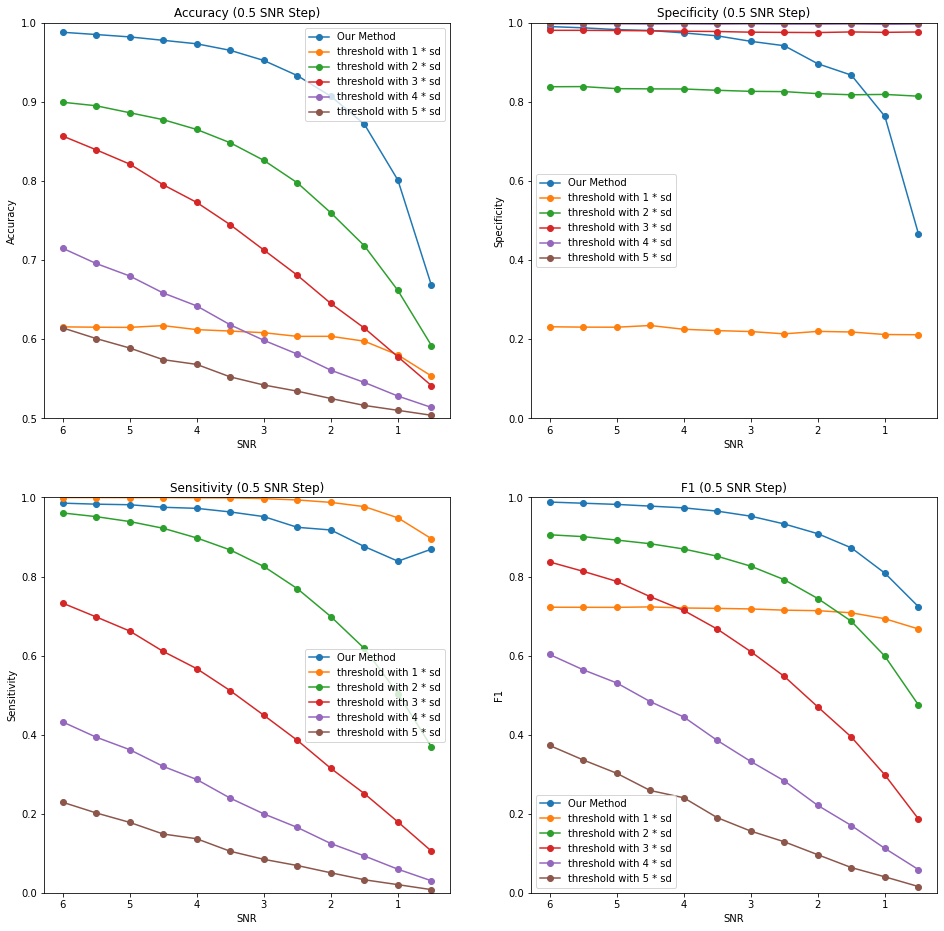

In [14]:
snr = [6.0, 5.5, 5.0, 4.5, 4.0, 3.5, 3.0, 2.5, 2.0, 1.5, 1.0, 0.5]
plt.rcParams['figure.figsize'] = [16, 16]

#plt.plot(np.sort(scale))
plt.show()

fig, axs = plt.subplots(2,2)

axs[0][0].title.set_text("Accuracy (0.5 SNR Step)")
axs[0][1].title.set_text("Specificity (0.5 SNR Step)")
axs[1][0].title.set_text("Sensitivity (0.5 SNR Step)")
axs[1][1].title.set_text("F1 (0.5 SNR Step)")
axs[0][0].set_xlabel("SNR")
axs[0][1].set_xlabel("SNR")
axs[1][0].set_xlabel("SNR")
axs[1][1].set_xlabel("SNR")
axs[0][0].set_ylabel("Accuracy")
axs[0][1].set_ylabel("Specificity")
axs[1][0].set_ylabel("Sensitivity")
axs[1][1].set_ylabel("F1")

axs[0][0].plot(snr, allAccuracy, label="Our Method", marker='o')
axs[0][1].plot(snr, allSpecificity, label="Our Method", marker='o')
axs[1][0].plot(snr, allRecall, label="Our Method", marker='o')
axs[1][1].plot(snr, allF1, label="Our Method", marker='o')

for x in multiplesOfSd:
    axs[0][0].plot(snr, accDict[x], label=f"threshold with {x} * sd", marker='o')
    axs[0][1].plot(snr, specDict[x], label=f"threshold with {x} * sd", marker='o')
    axs[1][0].plot(snr, recallDict[x], label=f"threshold with {x} * sd", marker='o')
    axs[1][1].plot(snr, f1Dict[x], label=f"threshold with {x} * sd", marker='o')
    
axs[0][0].legend()
axs[0][1].legend()
axs[1][0].legend()
axs[1][1].legend()

axs[0][0].set_ylim([0.5,1])
axs[0][1].set_ylim([0,1])
axs[1][0].set_ylim([0,1])
axs[1][1].set_ylim([0,1])
axs[0][0].invert_xaxis()
axs[0][1].invert_xaxis()
axs[1][0].invert_xaxis()
axs[1][1].invert_xaxis()

plt.show()
plt.rcParams['figure.figsize'] = [16, 8]    

In [15]:
print("Accuracy")
print(accDict)
print("Precision")
print(precisionDict)
print("Recall")
print(recallDict)
print("Specificity")
print(specDict)
print("F1")
print(f1Dict)
print("snrs")
print([x/2 for x in range(12,0,-1)])

Accuracy
{1: [0.6157444436365399, 0.61530817518602, 0.61509004096076, 0.6173198574856394, 0.6122542960323808, 0.6104365108218813, 0.6083763542499818, 0.603722824111103, 0.603795535519523, 0.5976393029399646, 0.5802612763275892, 0.5535761894374561], 2: [0.8998521534695461, 0.8953925204197872, 0.8865944400009694, 0.8777963595821517, 0.865411183014615, 0.8485906105334594, 0.8263651566930852, 0.7979592331370126, 0.7600281150779223, 0.7182675295087132, 0.6617465280302479, 0.592137473036186], 3: [0.8571947938631571, 0.8397440558423617, 0.8216631522819263, 0.7954870452507332, 0.773164642865799, 0.7449283792627063, 0.7130323081024746, 0.6810392883976829, 0.6453622239996122, 0.6141690297874404, 0.5778860369858697, 0.5414091470951793], 4: [0.7152378874912141, 0.695920889987639, 0.6801425143605032, 0.6586199374681888, 0.642259870573693, 0.6183620543396592, 0.5987784483385443, 0.5813277103177489, 0.5609200416878741, 0.5454325116944182, 0.5282241450350227, 0.5138515233040064], 5: [0.614508349693400

torch.Size([23961, 80])


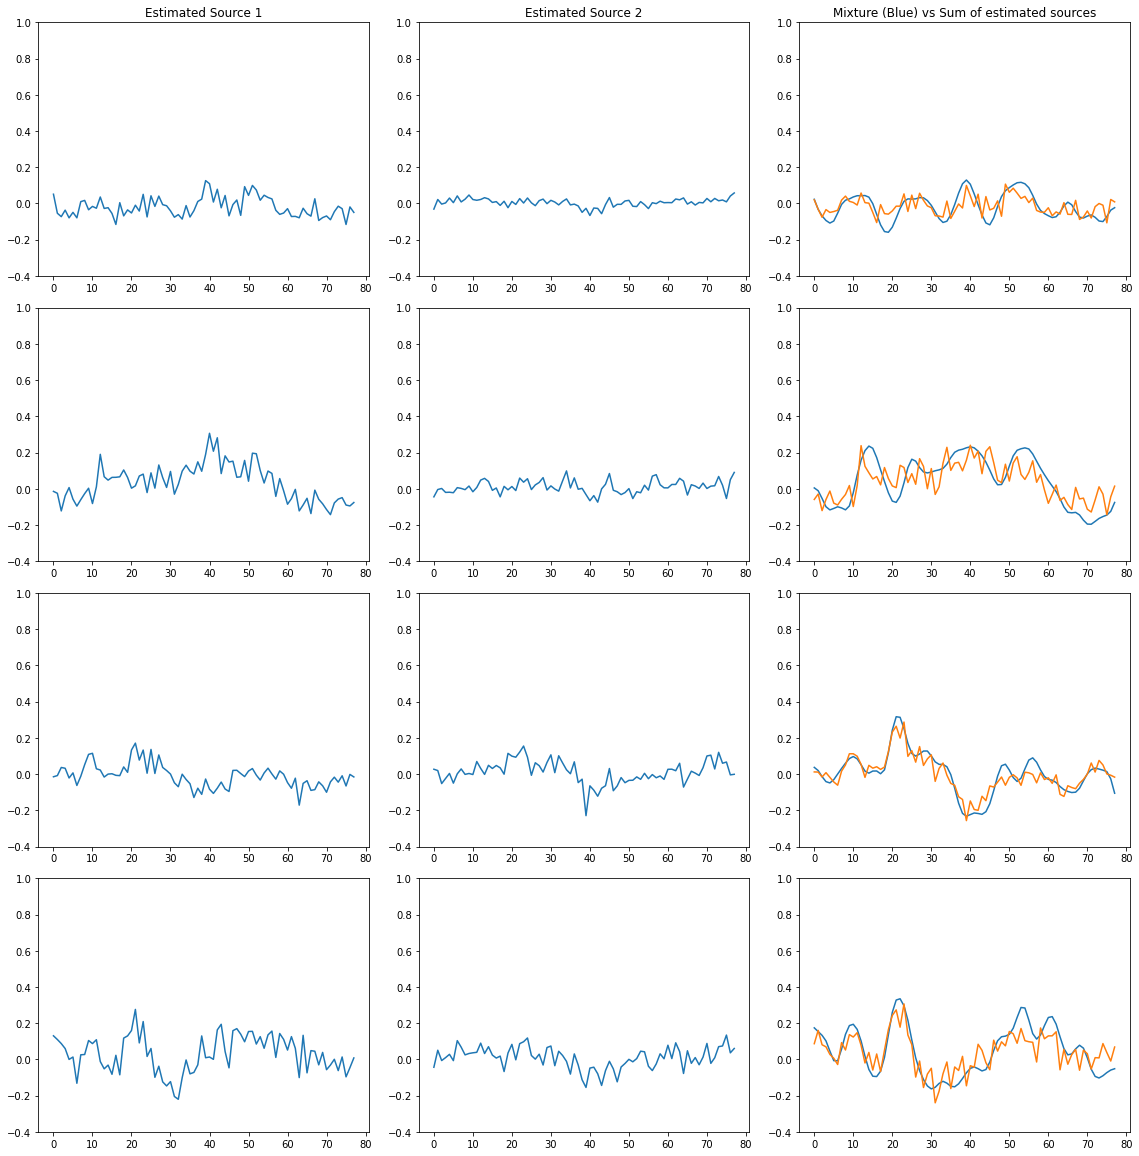

In [50]:
# separates the spike samples

(cleanextractedSpikesValidationSpikes,cleanextractedNoisesValidationSpikes) = sourceSeparation.maxlikelihood_separatesources(
    generators=[gen1, gen2],
    loader_mix=valSpikesLoader,
    epochs=3000
)

torch.Size([23961, 80])


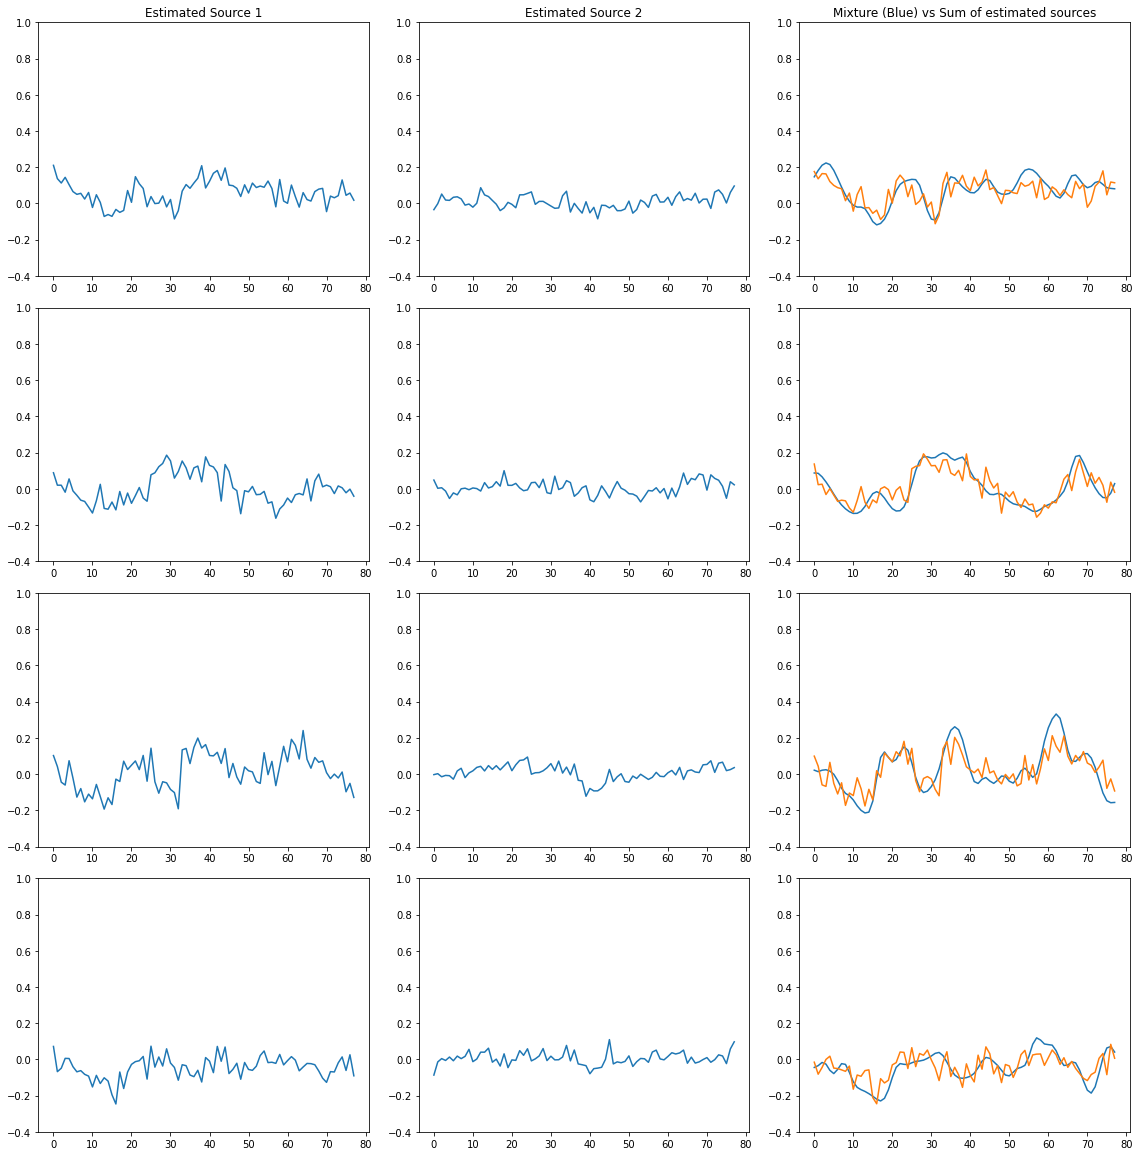

In [51]:
# separates the noise samples

(cleanextractedSpikesValidationBg,cleanextractedNoisesValidationBg) = sourceSeparation.maxlikelihood_separatesources(
    generators=[gen1, gen2],
    loader_mix=valBgLoader,
    epochs=3000
)

In [52]:
valExtractedSpikes = np.concatenate((cleanextractedSpikesValidationSpikes,cleanextractedSpikesValidationBg),axis=0)
vallabel = np.concatenate(([1 for _ in cleanextractedSpikesValidationSpikes],[0 for _ in cleanextractedSpikesValidationBg]),axis=0)

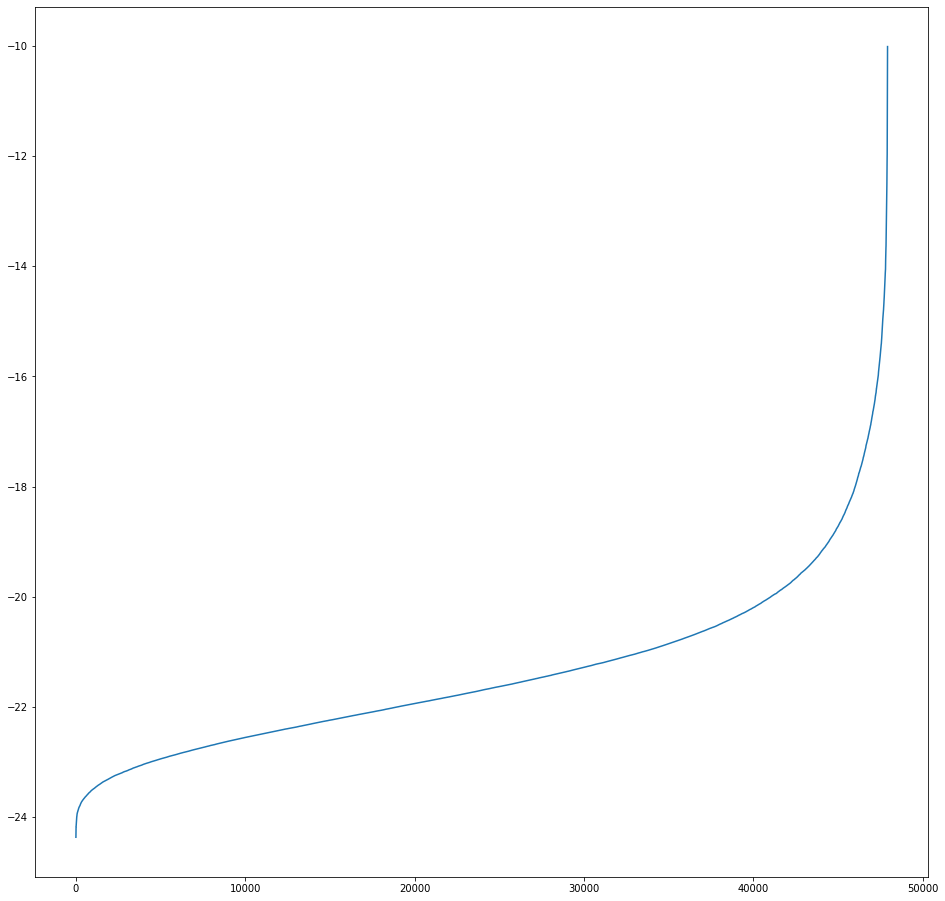

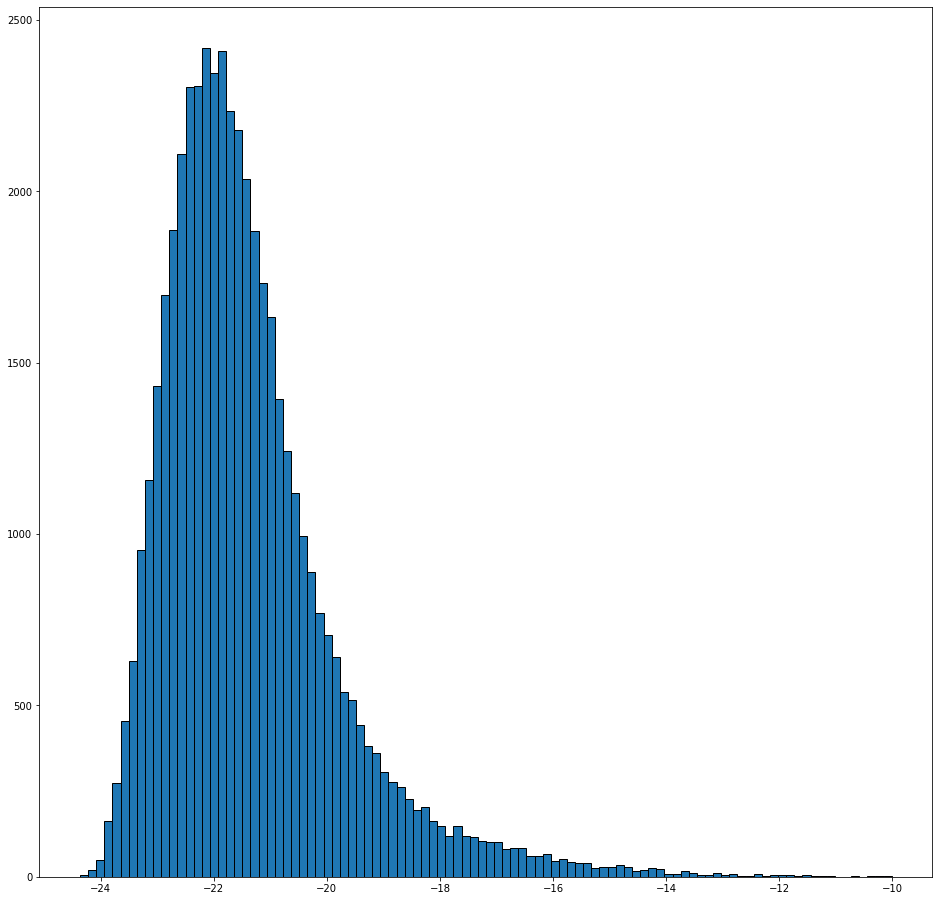

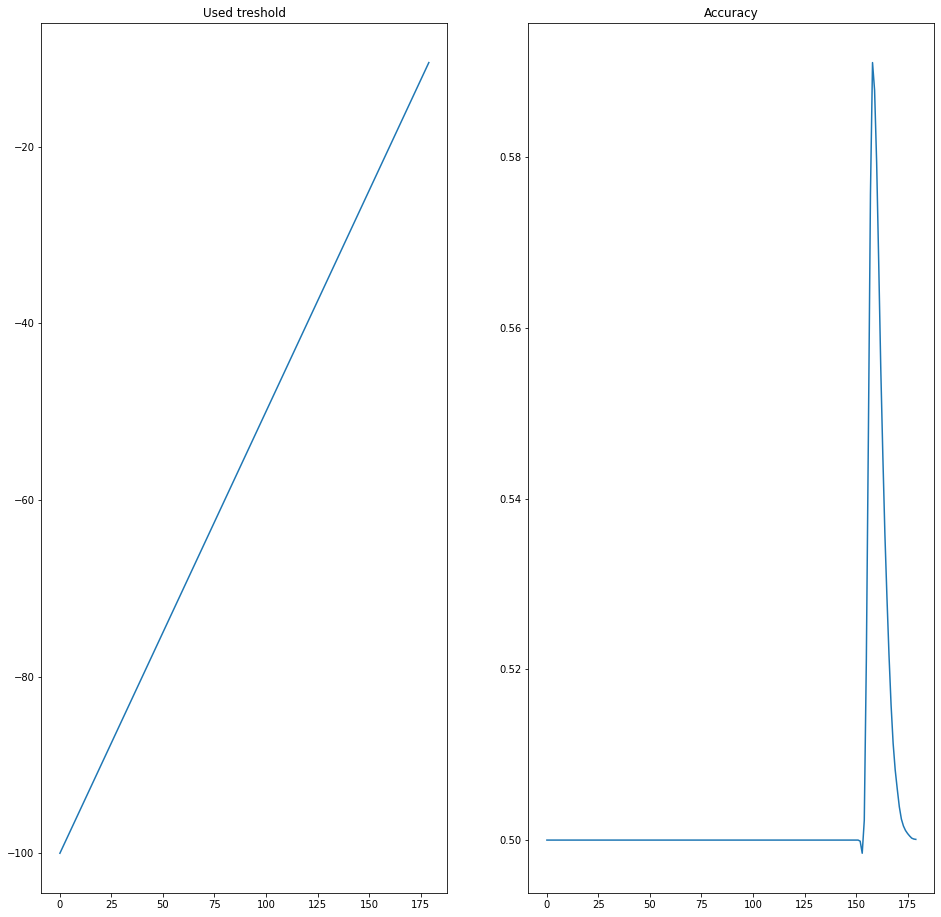

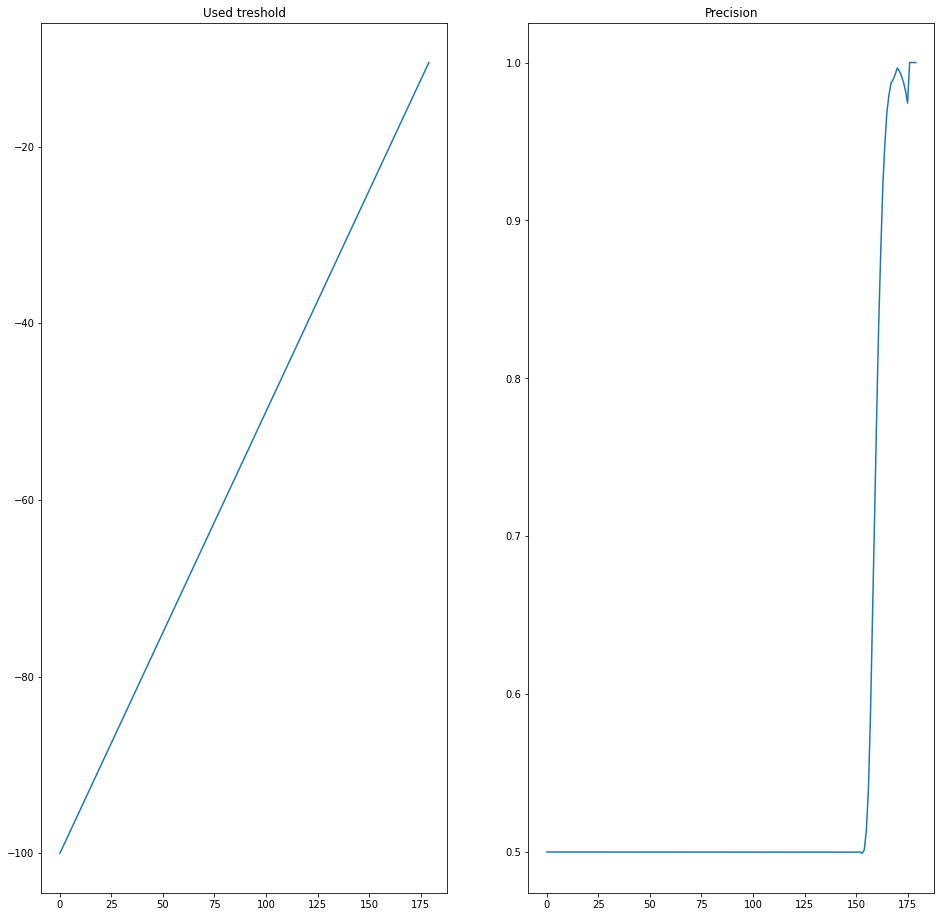

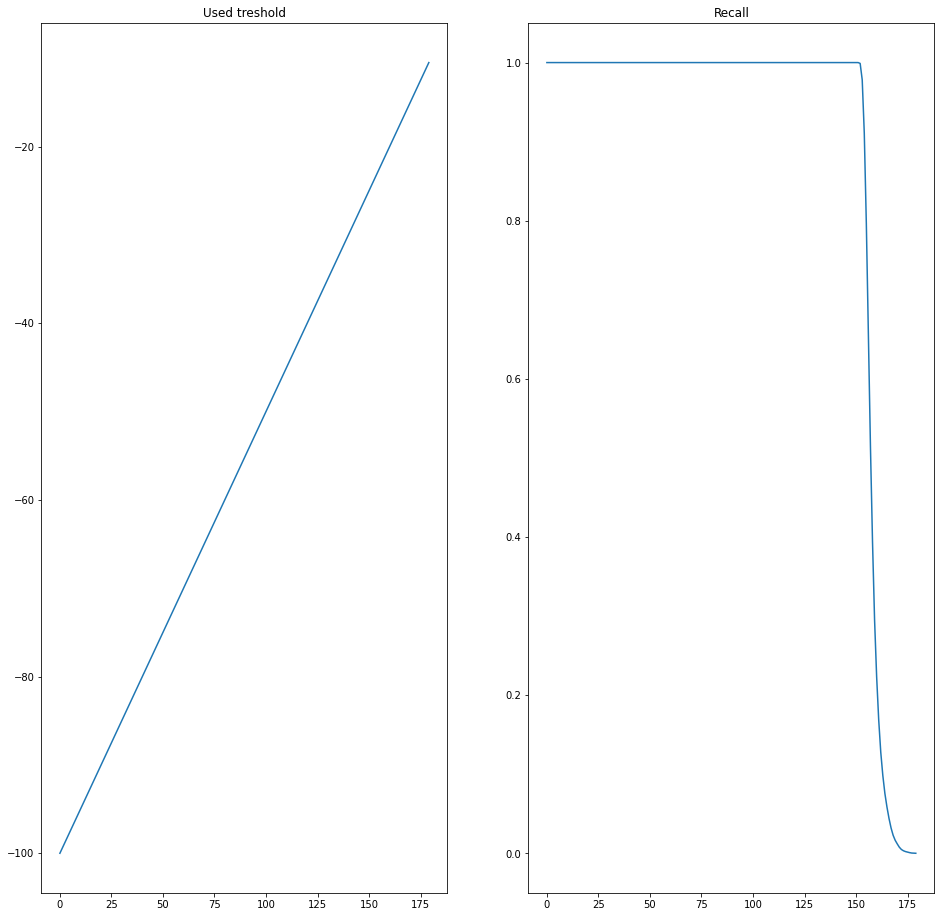

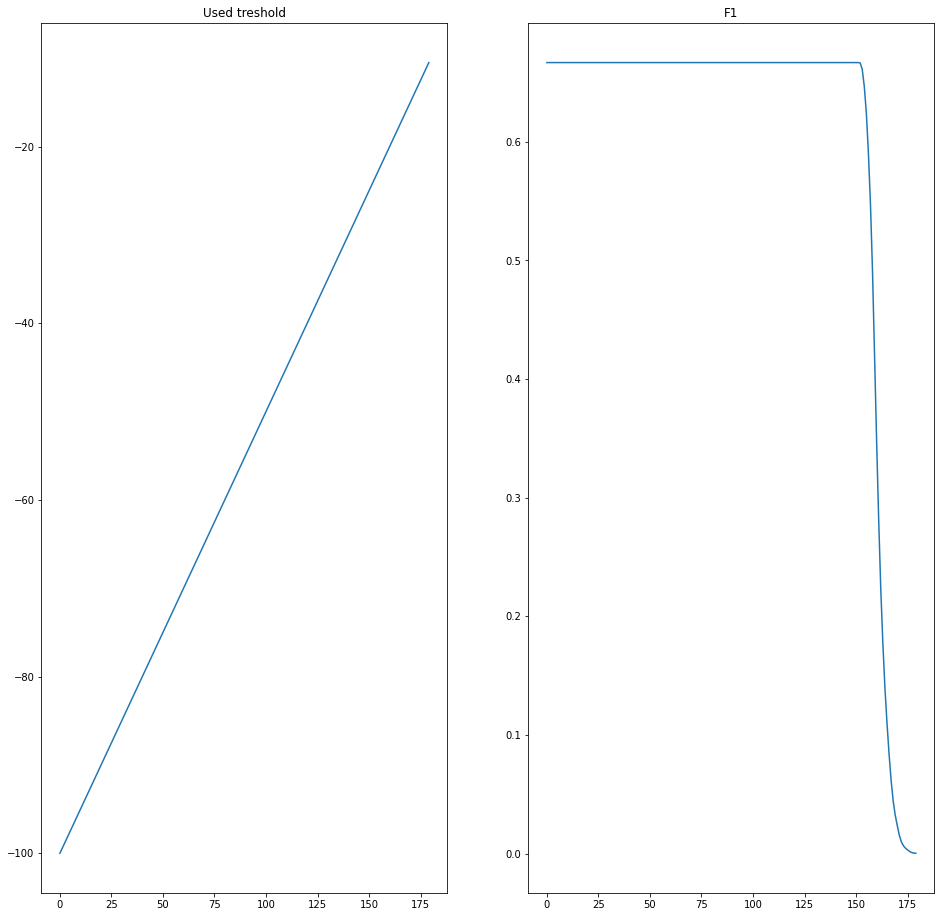

Threshold for best F1: -100.0
Threshold: -100.0
Precision: 0.5
Recall: 1.0
F1: 0.6666666666666666
Accuracy: 0.5


In [53]:
sourceSeparation.interpretSeparation(valExtractedSpikes, critic1, vallabel,method="critic")

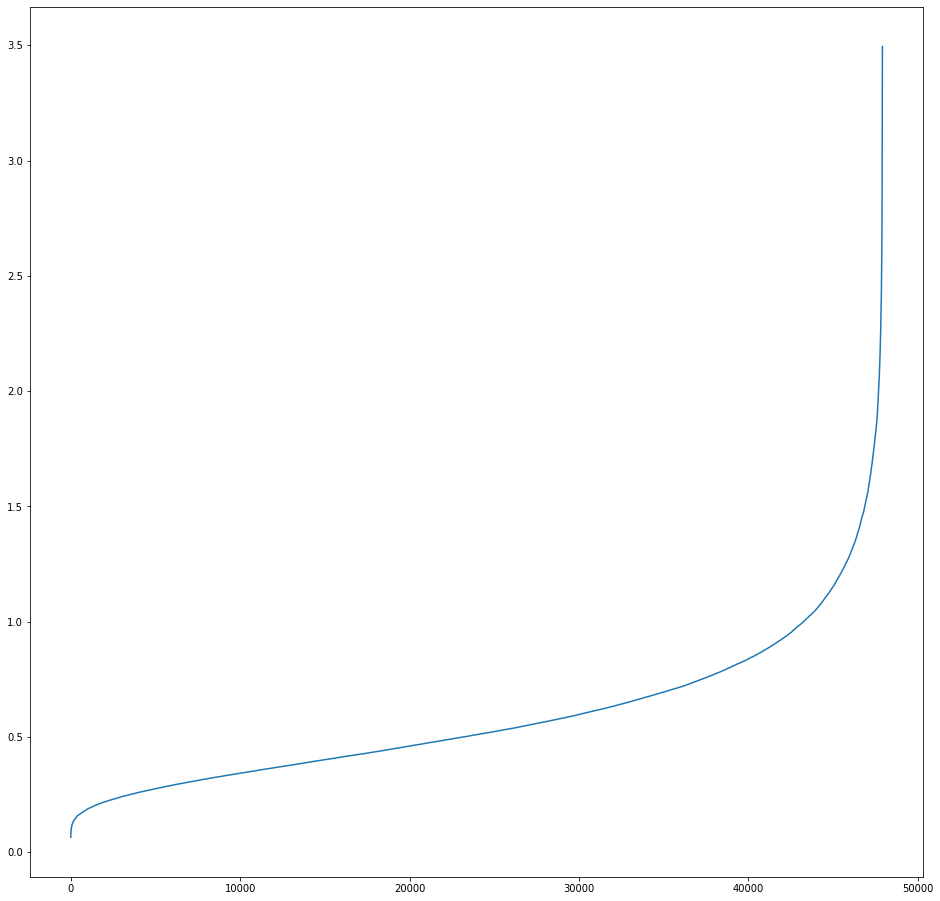

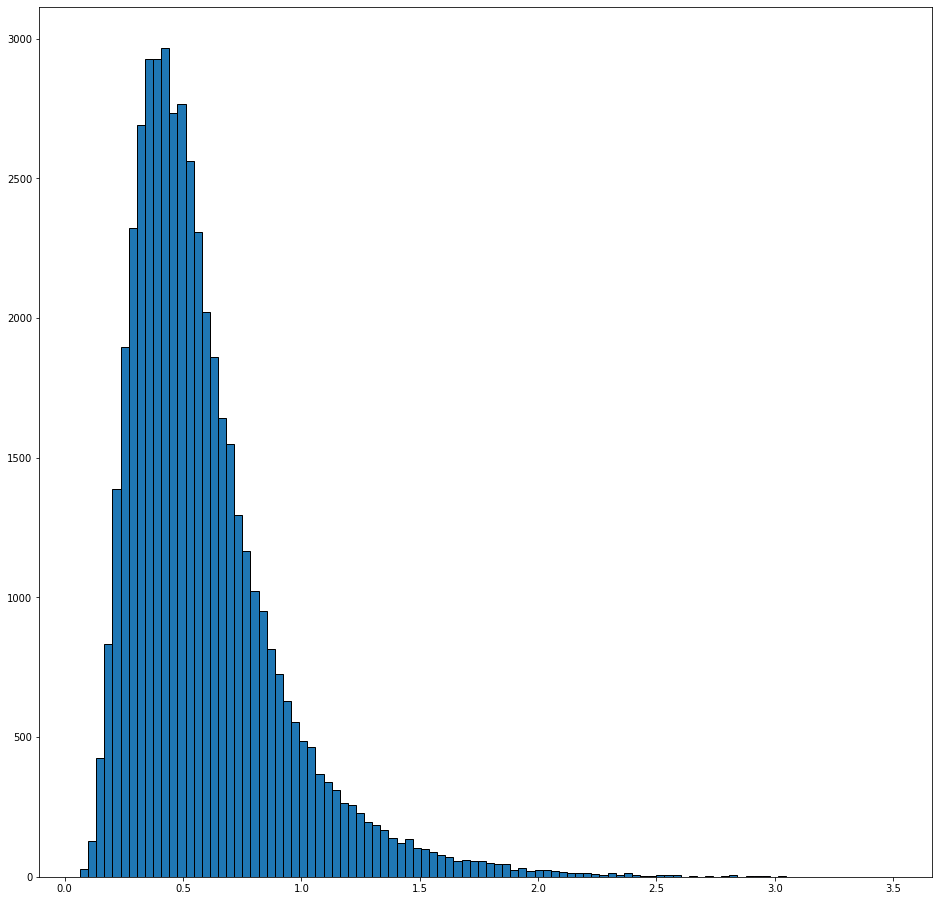

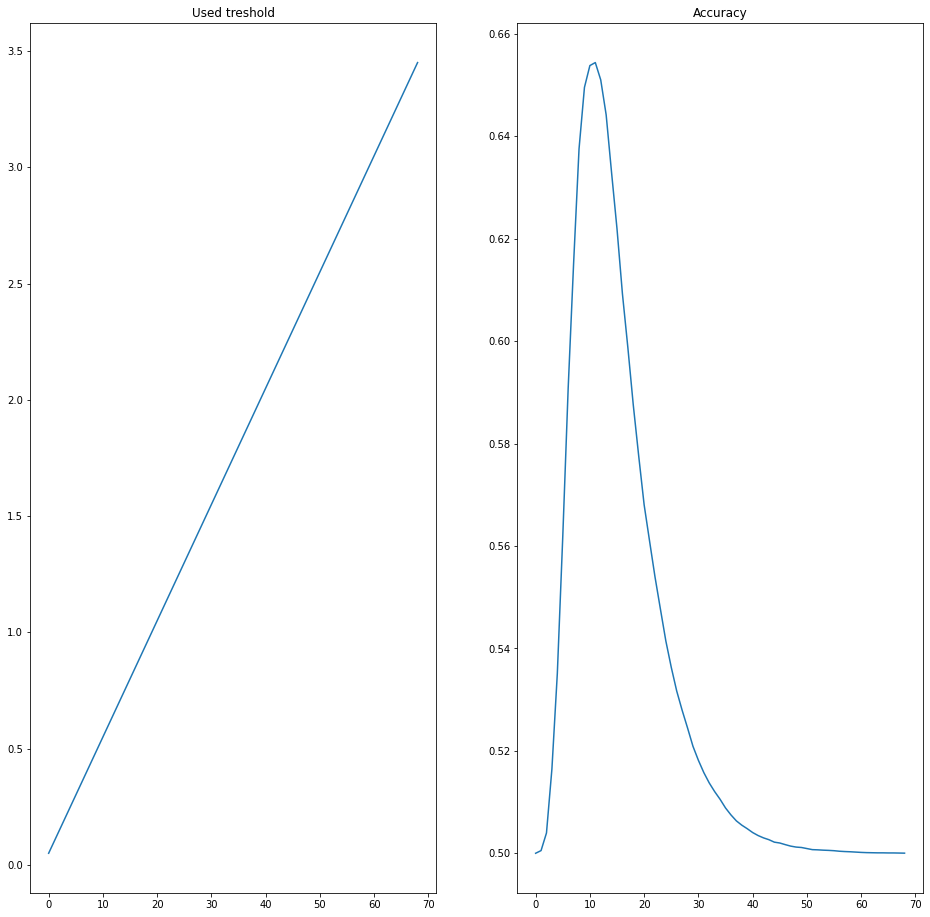

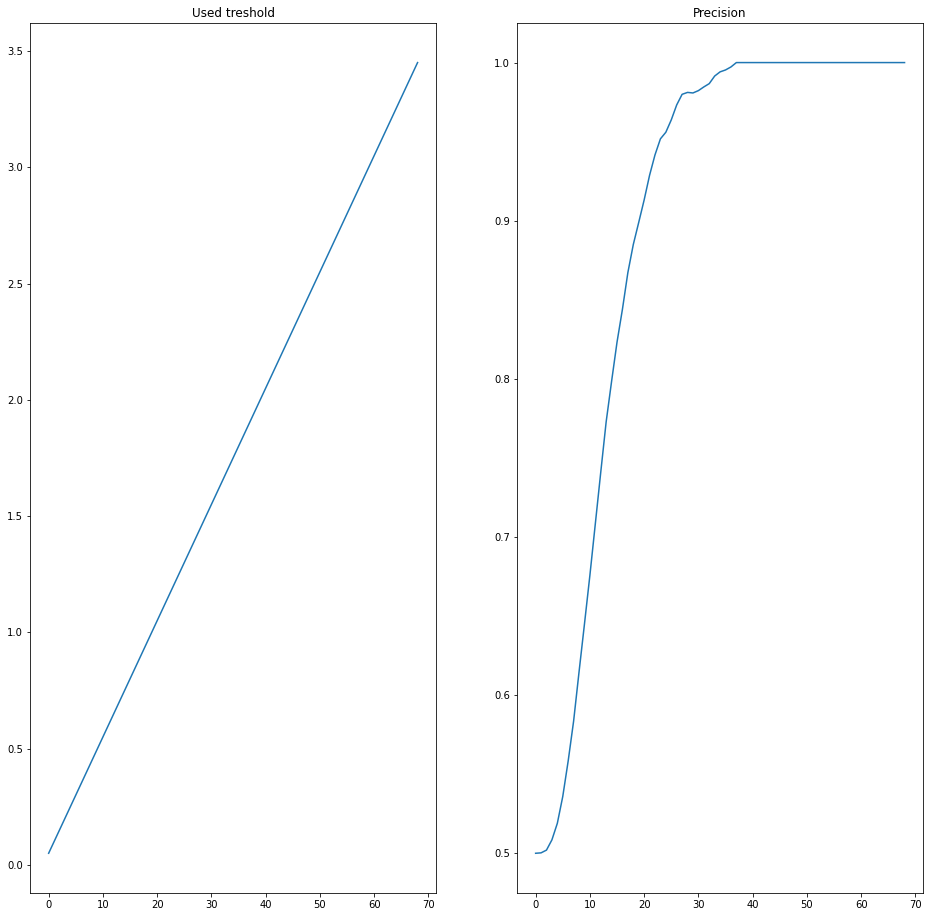

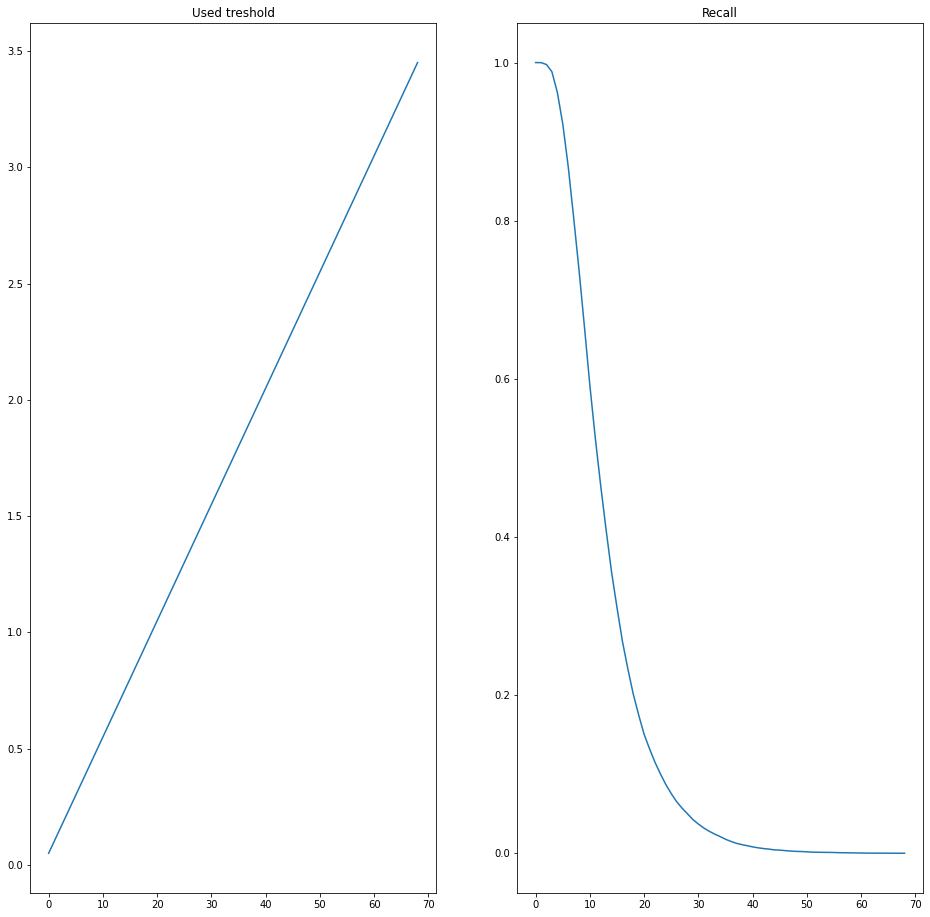

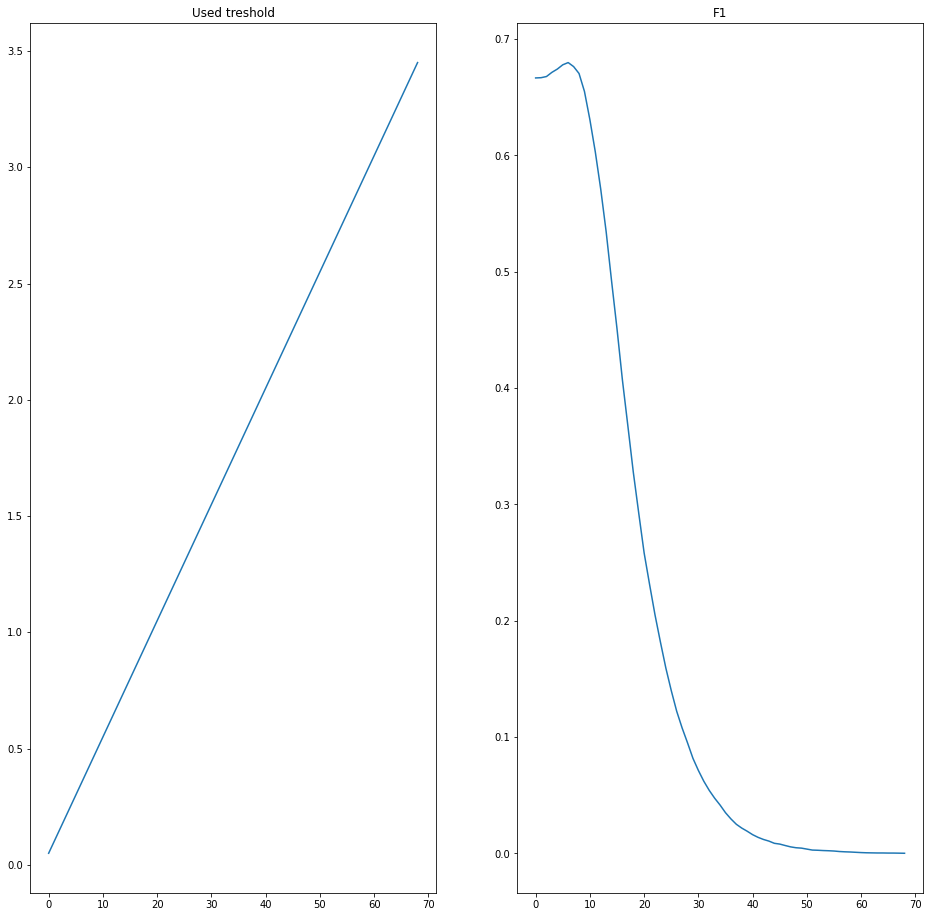

Threshold for best F1: 0.35
Threshold: 0.35
Precision: 0.5583652892118742
Recall: 0.8689954509411126
F1: 0.6798798406582642
Accuracy: 0.5908351070489546


In [54]:
sourceSeparation.interpretSeparation(valExtractedSpikes, critic1, vallabel,method="energy")

torch.Size([23949, 80])


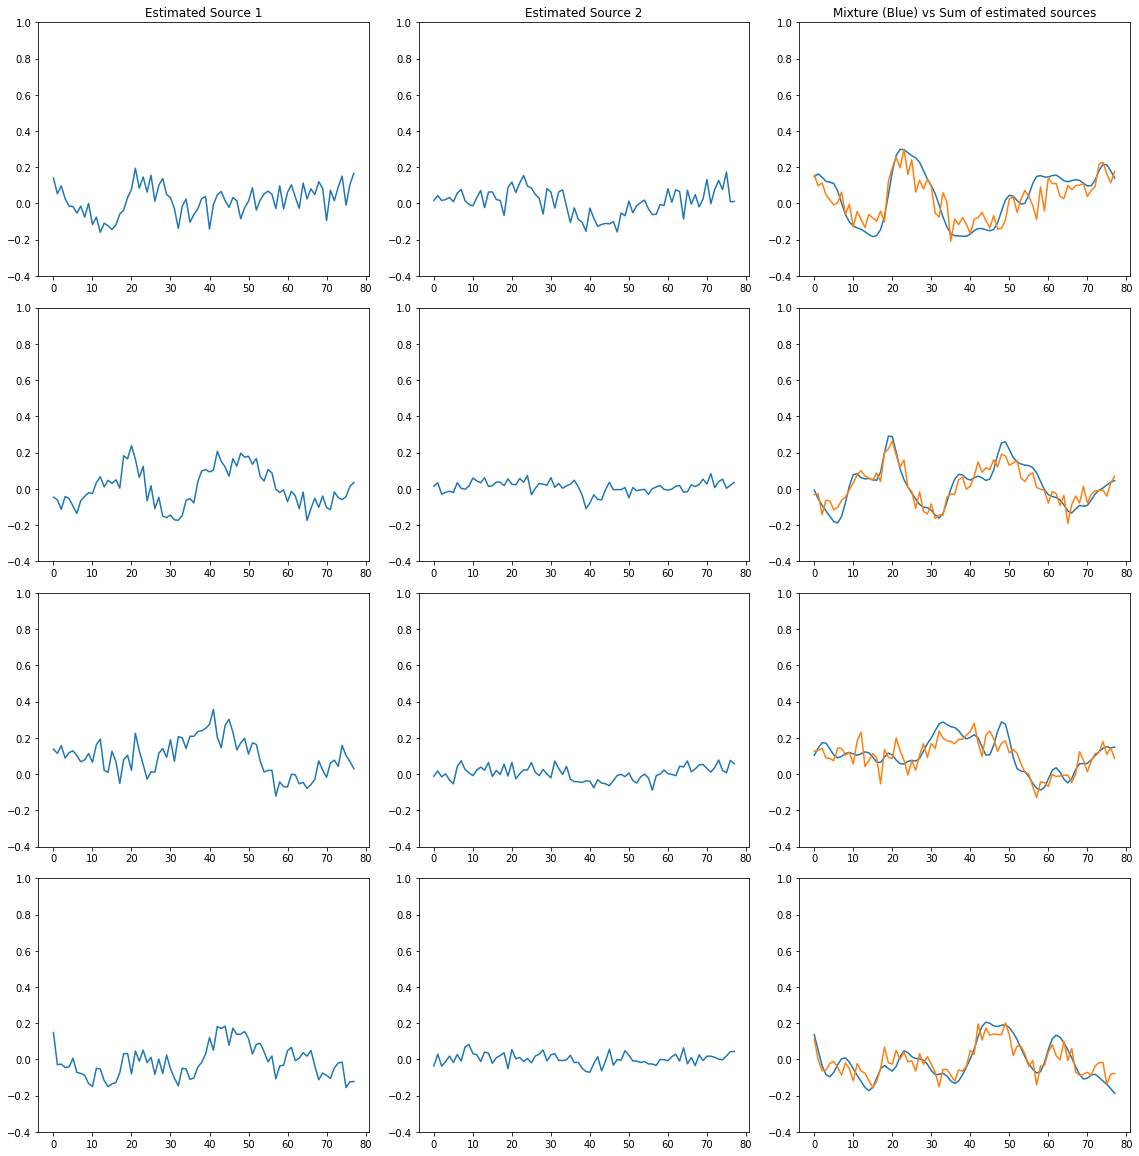

In [55]:
# separates the spike samples

(cleanextractedSpikesTestSpikes,cleanextractedNoisesTestSpikes) = sourceSeparation.maxlikelihood_separatesources(
    generators=[gen1, gen2],
    loader_mix=testSpikesLoader,
    epochs=3000
)

torch.Size([23949, 80])


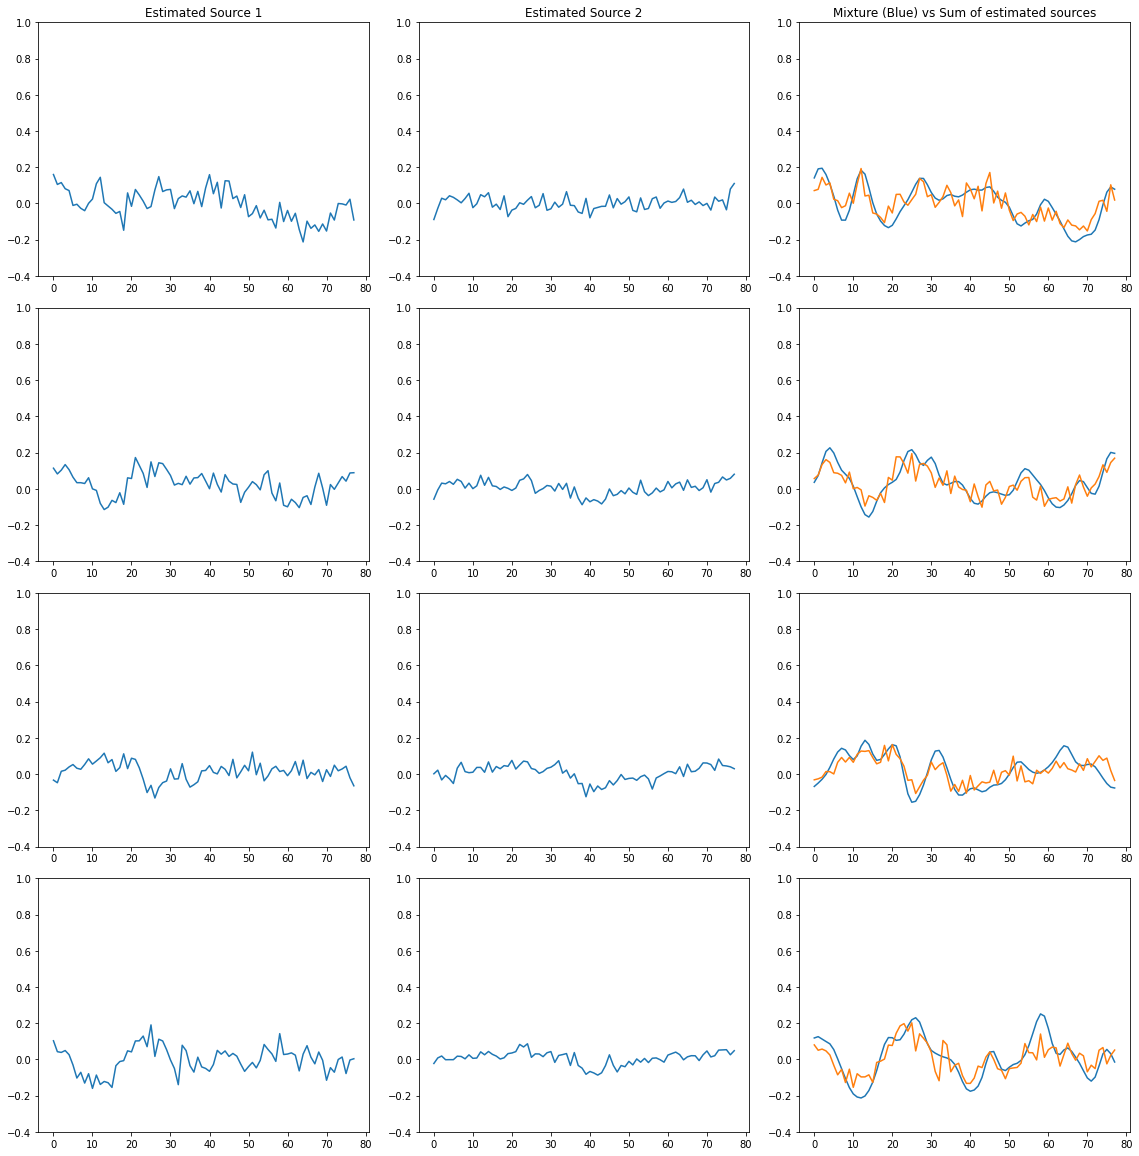

In [56]:
# separates the noise samples

(cleanextractedSpikesTestBg,cleanextractedNoisesTestBg) = sourceSeparation.maxlikelihood_separatesources(
    generators=[gen1, gen2],
    loader_mix=testBgLoader,
    epochs=3000
)

In [57]:
testExtractedSpikes = np.concatenate((cleanextractedSpikesTestSpikes,cleanextractedSpikesTestBg),axis=0)
testlabel = np.concatenate(([1 for _ in cleanextractedSpikesTestSpikes],[0 for _ in cleanextractedSpikesTestBg]),axis=0)

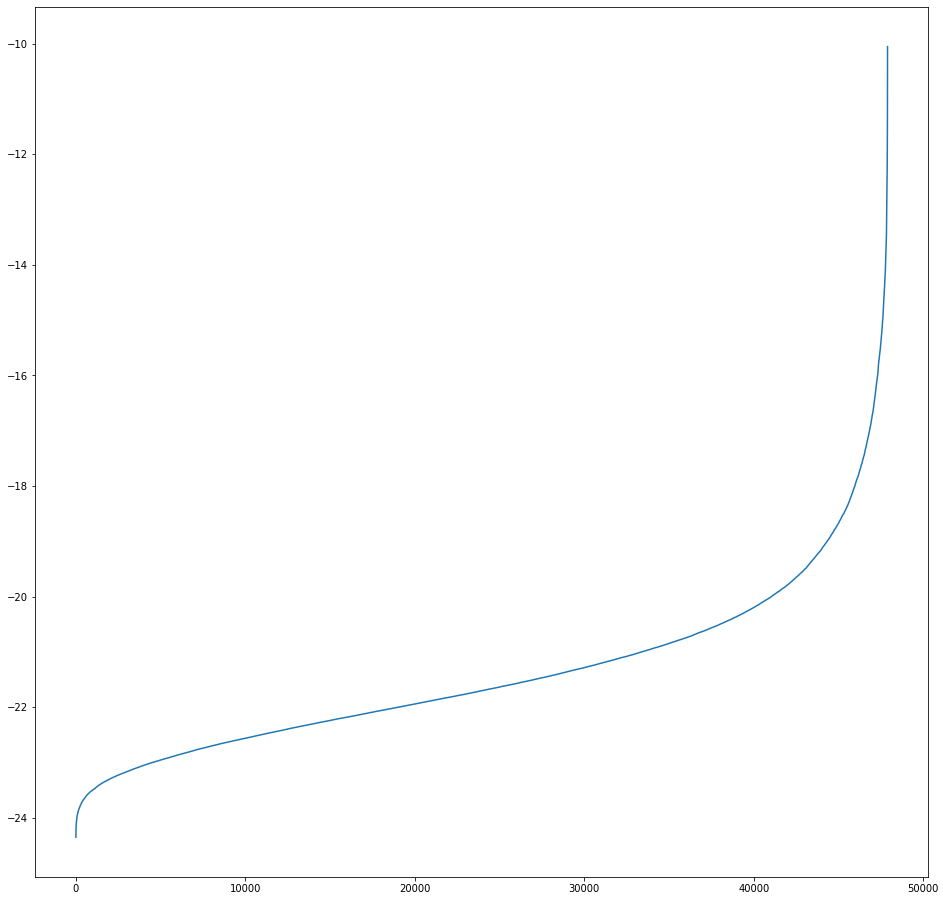

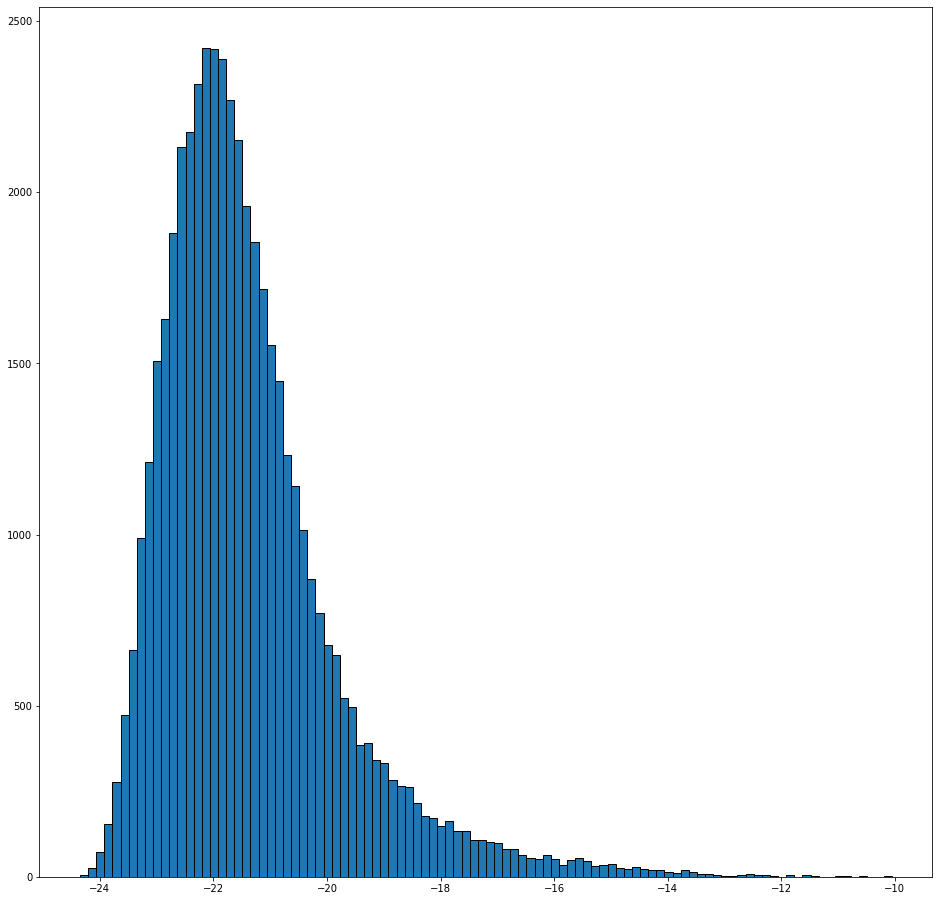

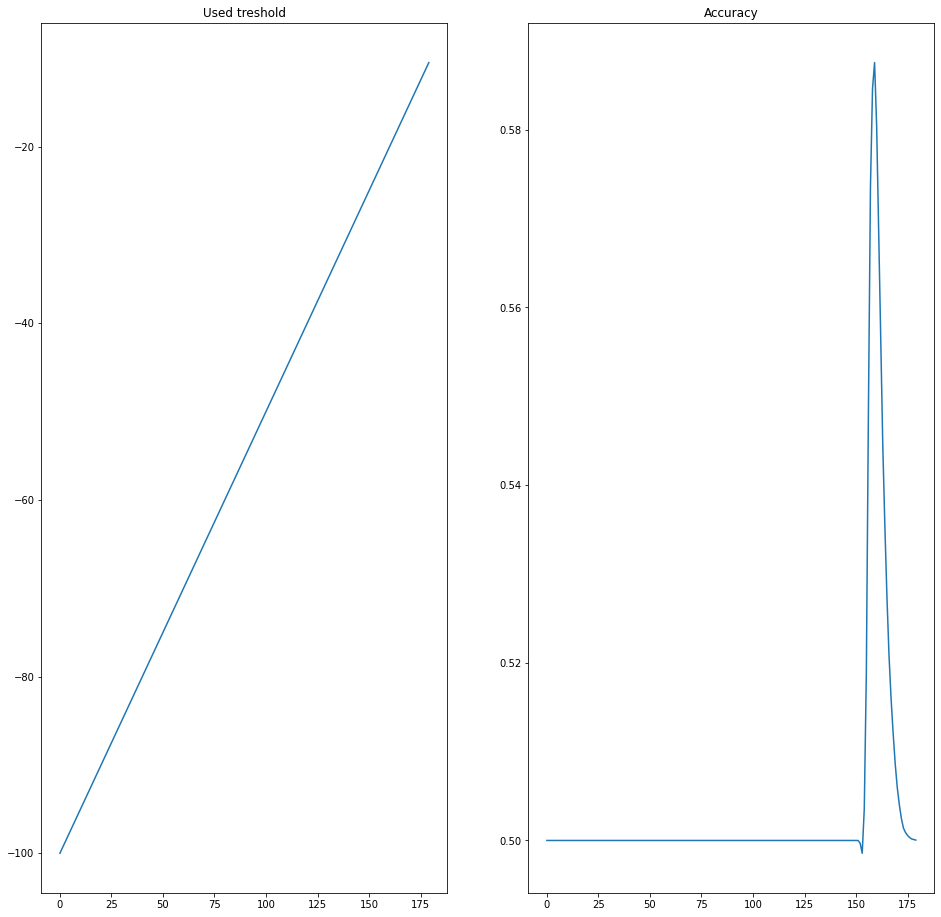

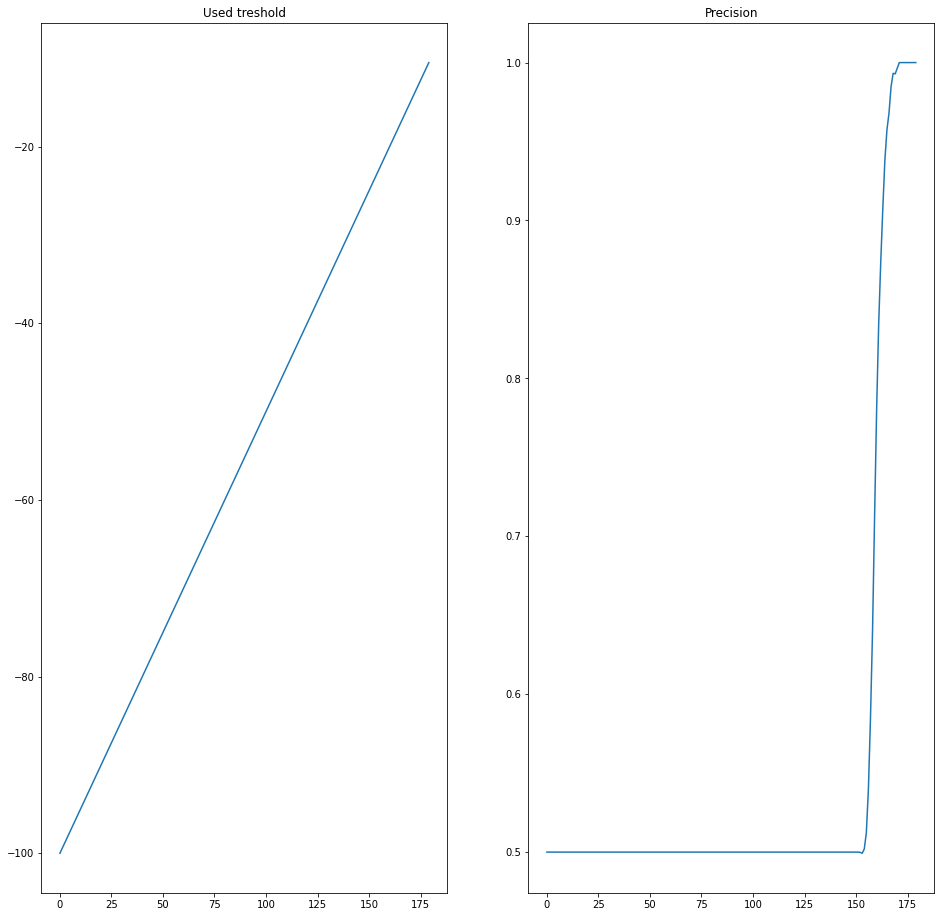

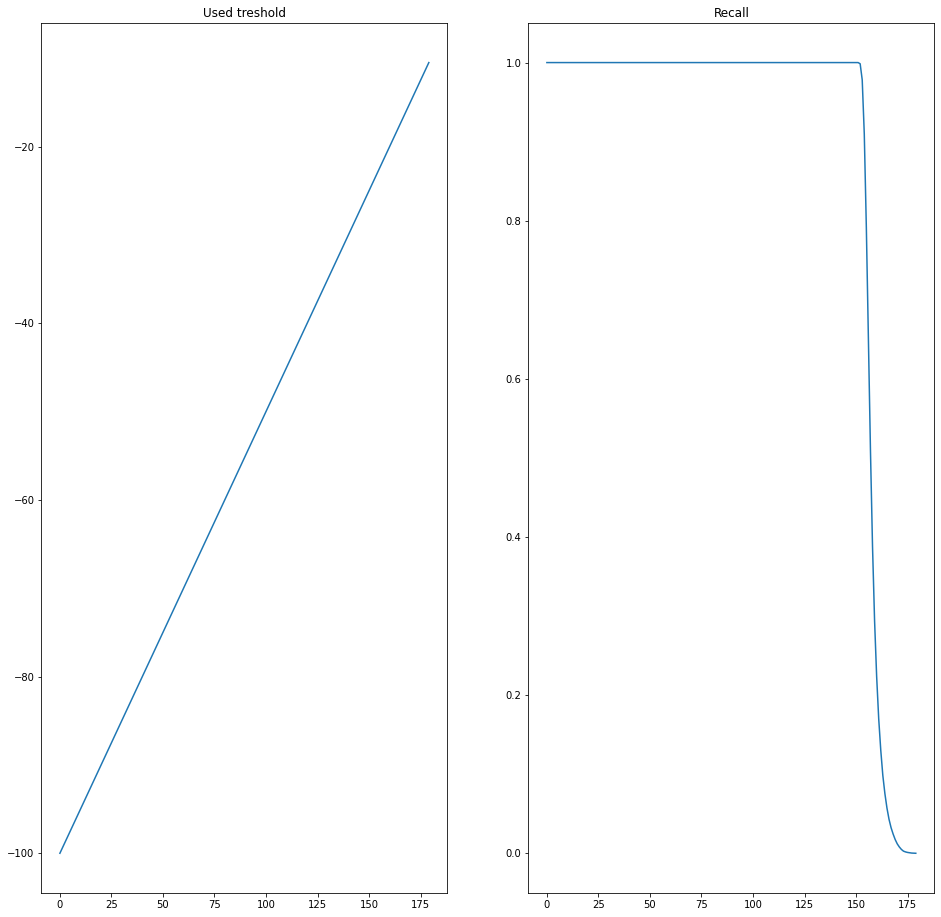

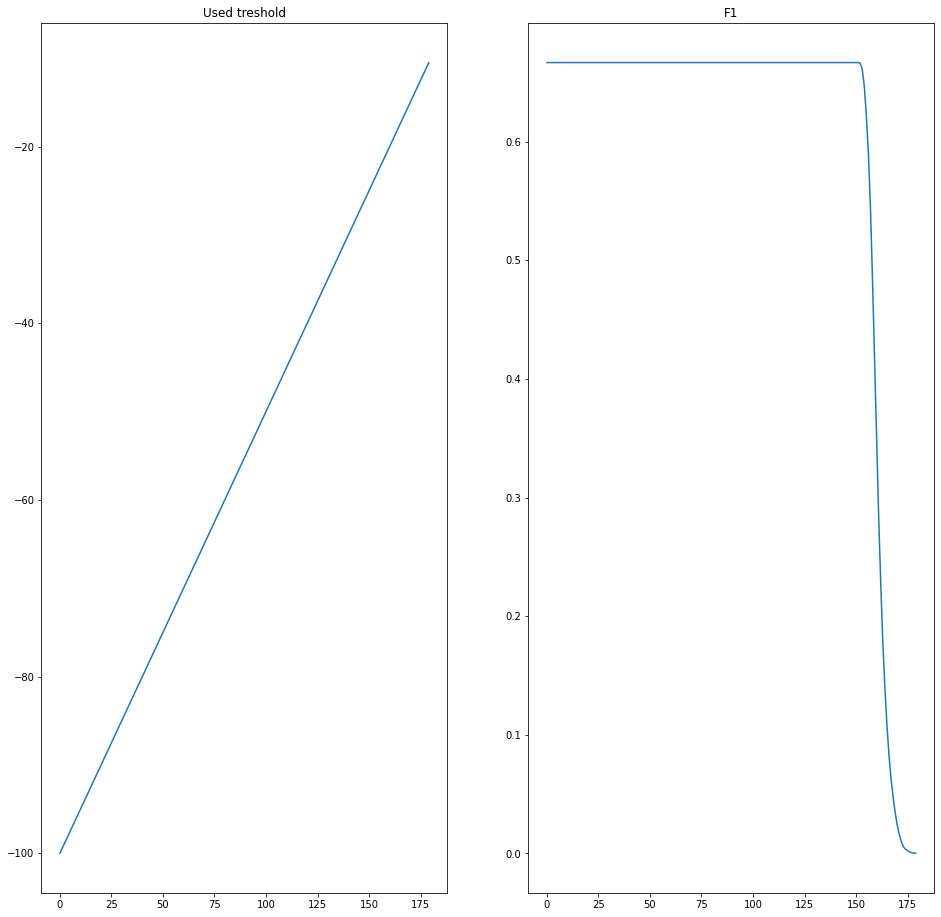

Threshold for best F1: -100.0
Threshold: -21.5
Precision: 0.5843869731800766
Recall: 0.5094993527913483
F1: 0.5443797541769836
Accuracy: 0.5735730093114535


In [60]:
sourceSeparation.interpretSeparation(testExtractedSpikes, critic1, testlabel,test=True, testThreshold=-21.5,method="critic")

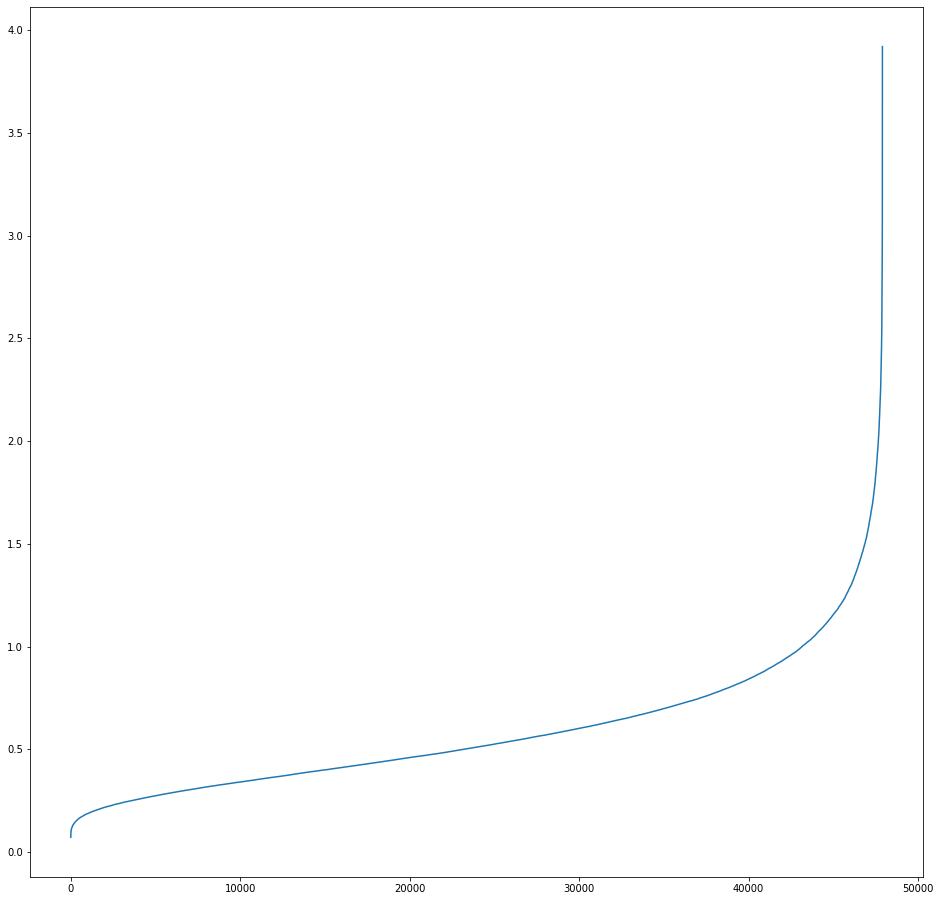

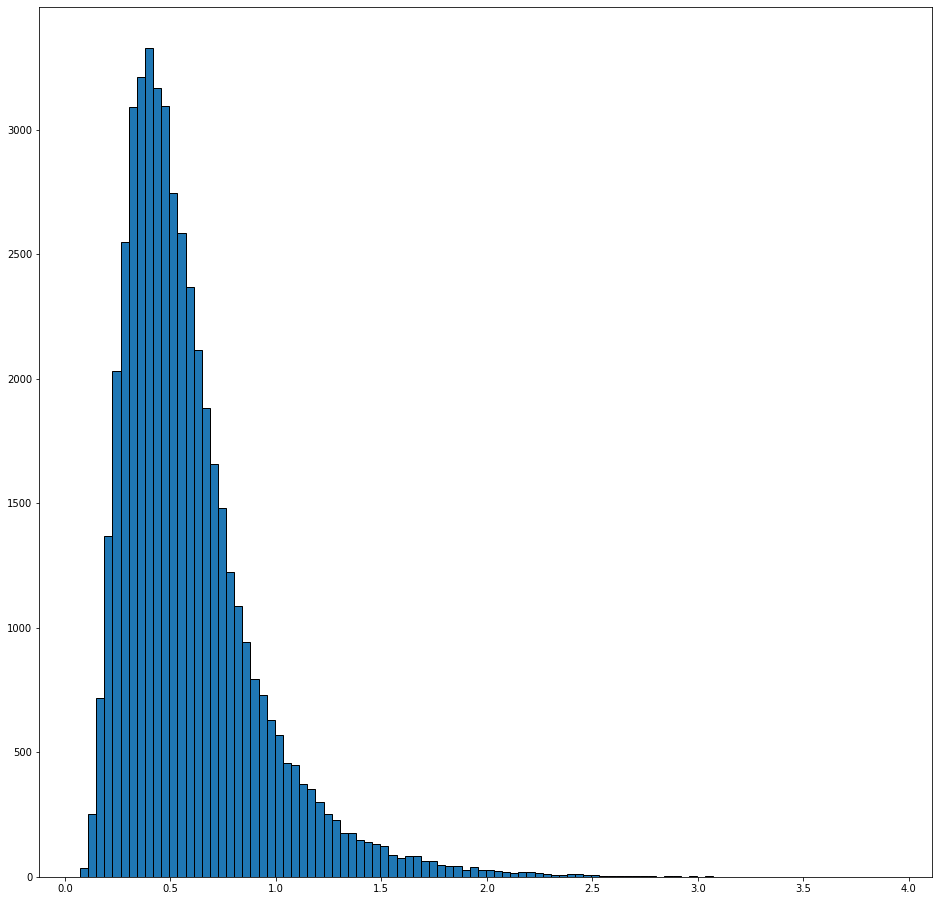

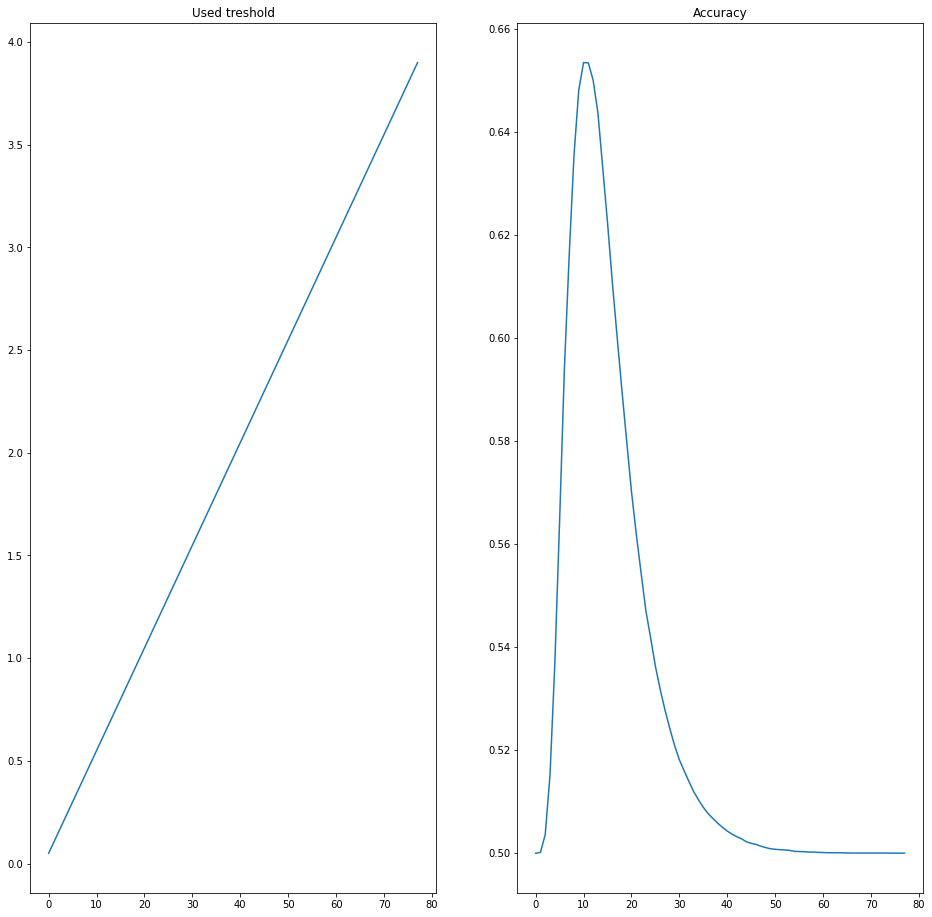

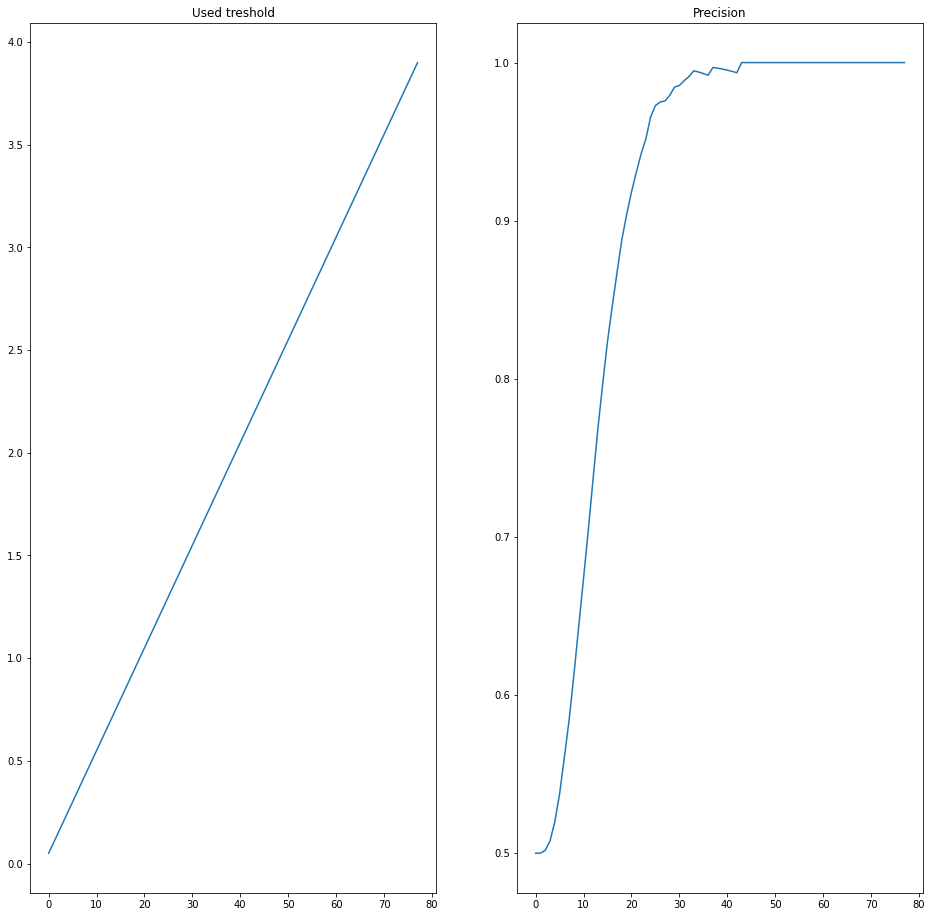

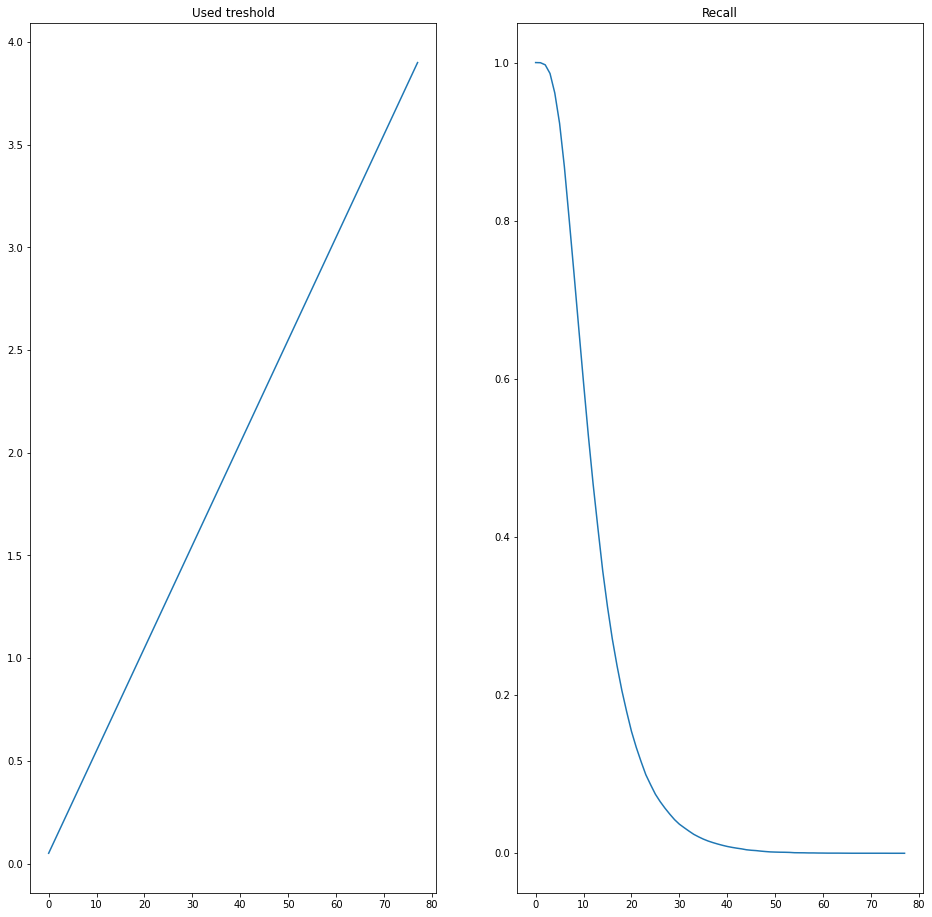

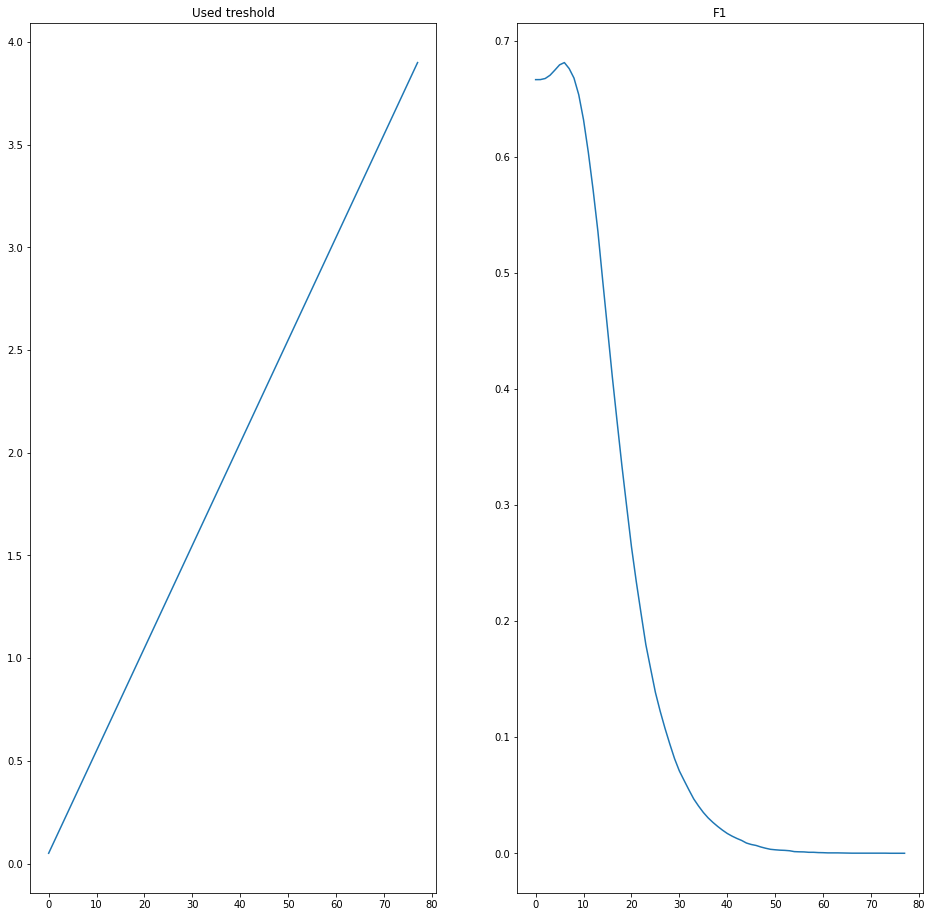

Threshold for best F1: 0.35
Threshold: 0.35
Precision: 0.5606632515502831
Recall: 0.8683034782245606
F1: 0.6813676501908615
Accuracy: 0.5939496429913567


In [59]:
sourceSeparation.interpretSeparation(testExtractedSpikes, critic1, testlabel,test=True, testThreshold=0.35,method="energy")